# Libraries

In [126]:
#import do_mpc
from casadi import *
from casadi.tools import *
import numpy as np
import scipy.integrate as scp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy.random as rnd
import torch
import copy
import torch.nn.functional as F
from scipy.optimize import minimize
from torch_pso import ParticleSwarmOptimizer
from scipy.signal import find_peaks
from stable_baselines3 import PPO,SAC
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
import gymnasium as gym
from gymnasium import spaces 

In [127]:
def sample_uniform_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min \
              for k, v in params_prev.items()}
    return params

def sample_local_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min + v \
              for k, v in params_prev.items()}
    return params


# Process Environment

In [128]:
def PID(Ks, x, x_setpoint, e_history):

    # K gains
    KpCa = Ks[0]; KiCa = Ks[1]; KdCa = Ks[2]
    KpT  = Ks[3]; KiT  = Ks[4]; KdT  = Ks[5]; Kb = Ks[6]
    # setpoint error

    e = x_setpoint - x
    # if Ks[0] == 0 and Ks[1] == 0 and Ks[2] == 0:
    #   e = x - x_setpoint
    # control action

    u = KpT *e[1] + KiT *sum(e_history[:,1]) + KdT *(e[1]-e_history[-1,1])
    u -= KpCa*e[0] + KiCa*sum(e_history[:,0]) + KdCa*(e[0]-e_history[-1,0])
    u += Kb
    u = min(max(u,290),310)


    return u

In [129]:
def cstr_CS1(x,t,u,Tf,Caf,k0,UA):

    # ==  Inputs (3) == #
    Tc = u # Temperature of cooling jacket (K)
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # == States == #
    Ca = x[0] # Concentration of A in CSTR (mol/m^3)
    T  = x[1] # Temperature in CSTR (K)

    # == Process parameters == #
    q      = 100    # Volumetric Flowrate (m^3/sec)
    V      = 100    # Volume of CSTR (m^3)
    rho    = 1000   # Density of A-B Mixture (kg/m^3)
    Cp     = 0.239  # Heat capacity of A-B Mixture (J/kg-K)
    mdelH  = 5e4    # Heat of reaction for A->B (J/mol)
    EoverR = 8750   # E -Activation energy (J/mol), R -Constant = 8.31451 J/mol-1
    rA     = k0*np.exp(-EoverR/T)*Ca # reaction rate
    dCadt  = q/V*(Caf - Ca) - rA     # Calculate concentratioing n derivative
    dTdt   = q/V*(Tf - T) \
              + mdelH/(rho*Cp)*rA \
              + UA/V/rho/Cp*(Tc-T)   # Calculate temperature derivative

    # == Return xdot == #
    xdot    = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot


In [416]:
def Case_Study_1(Ks_opt,model,policy,SP,ns,minimise,full_output,disturb,k0,UA):
    # Steady State Initial Conditions for the States
    Ca_ss = 0.87725294608097
    T_ss  = 324.475443431599
    x0    = np.empty(2)
    x0[0] = Ca_ss
    x0[1] = T_ss

    # desired steady states
    Ca_des = SP[0]
    T_des  = SP[1]

    u_ss = 300.0 # Steady State Initial Condition


    Caf  = 1     # Feed Concentration (mol/m^3)

    # Time Interval (min)
    t = np.linspace(0,25,ns)

    # Store results for plotting
    Ca = np.ones(len(t)) * Ca_ss
    T  = np.ones(len(t)) * T_ss
    u  = np.ones(len(t)) * u_ss
    Ks_list = np.zeros((7,len(t)))
    Tf = np.ones(len(t))*350 # Feed Temperature (K)

    if disturb:
      Tf[10:30] = 360
    # Simulate CSTR
    e_history = []
    if minimise == False:
      
      x_norm   = np.array([[.85, 326,.85, 326,0.85, 320],[.1, 20,.1, 20,.1, 20]])
      
      xk = torch.tensor(np.hstack((Ca[0],T[0],Ca[0],T[0],Ca_des[0],T_des[0])))
      state_norm = ((xk-x_norm[0])/x_norm[1])
      Ks = np.abs(policy(state_norm).detach().numpy()) #Ca, T, u, Ca setpoint and T setpoint
      #Adjust bounds from relu

      for ks_i in range(0,3):
          Ks[ks_i] = (Ks[ks_i])*6
          Ks_list[ks_i,0] = Ks[ks_i]
      for ks_i in range(3,6):
          Ks[ks_i] = (Ks[ks_i])*3
          Ks_list[ks_i,0] = Ks[ks_i]
      Ks[6] = (Ks[ks_i]) + 300
      Ks_list[6,0] = Ks[6]
    for i in range(1,120):
        # delta t


        ts      = [t[i-1],t[i]]
        # desired setpoint
        x_sp    = np.array([Ca_des[i],T_des[i]])
        # compute control
        if minimise == False:
          
          x_norm   = np.array([[.85, 326,.85, 326,0.85, 320],[.1, 20,.1, 20,.1, 20]])
          if i>1:
            xk = torch.tensor(np.hstack((Ca[i-1],T[i-1],Ca[i-2],T[i-2],Ca_des[i-1],T_des[i-1])))
          else:
            xk = torch.tensor(np.hstack((Ca[i-1],T[i-1],Ca[i-1],T[i-1],Ca_des[i-1],T_des[i-1])))




          state_norm = ((xk-x_norm[0])/x_norm[1])
          
          Ks = np.abs(policy(state_norm).detach().numpy()) #Ca, T, u, Ca setpoint and T setpoint
          #Adjust bounds from relu
          
          for ks_i in range(0,3):
              Ks[ks_i] = (Ks[ks_i])*6
              Ks_list[ks_i,i] = Ks[ks_i]
          for ks_i in range(3,6):
              Ks[ks_i] = (Ks[ks_i])*3
              Ks_list[ks_i,i] = Ks[ks_i]
          Ks[6] = (Ks[ks_i]) + 300
          Ks_list[6,i] = Ks[6]
     
        if minimise:
          Ks = Ks_opt
        if i == 1:
            u[i]  = PID(Ks, x0, x_sp, np.array([[0,0]]))
        else:
            u[i]  = PID(Ks, x0, x_sp, np.array(e_history))
        # simulate system
        y       = odeint(model,x0,ts,args=(u[i],Tf[i],Caf,k0,UA))
        # add process disturbance
        Ca[i] = y[-1][0] + np.random.uniform(low=-0.001,high=0.001)
        T[i]  = y[-1][1] + np.random.uniform(low=-.5,high=0.5)
        # collect data
        x0[0]   = Ca[i]
        x0[1]   = T[i]
        # compute tracking error
        e_history.append((x_sp-x0))
    #Penalise control action magnitude
    u_mag = np.abs(u[:]-295)/10 #250 is lower bound of jacket temperature
    u_mag = np.sum(u_mag/10)
    # penalise change in control action
    u_cha = np.abs(u[1:]-u[0:-1])/10
    u_cha = np.sum(u_cha/10)
    #Compute reward (squared distance + scaled)
    r_x = np.sum(np.abs(np.array(e_history)[:,0])/0.2+np.abs(np.array(e_history)[:,1])/15) + u_mag + u_cha
   
    data= {}
    data['t'] = t
    data['u'] = u
    data['Ca'] = Ca
    data['T'] = T
    data['e_history'] = e_history
    data['Ca_des'] = Ca_des
    data['T_des'] = T_des
    data['r_x'] = r_x
    data['ks'] = Ks_list
    if full_output:
        return data
    else:
        return np.sum(np.abs(np.array(e_history)[:,0])/0.2+np.abs(np.array(e_history)[:,1])/15) + u_mag + u_cha

# RL-PID

In [348]:
def plot_simulation(Ca_dat, T_dat, Tc_dat,ks_eval,SP,ns):

    Ca_des = SP[0]
    T_des  = SP[1]
    t = np.linspace(0,25,ns)

    plt.figure(figsize=(20, 18))
        
    plt.subplot(6,1,1)
    plt.plot(t, np.median(Ca_dat,axis=1), 'r-', lw=3)
    plt.gca().fill_between(t, np.min(Ca_dat,axis=1), np.max(Ca_dat,axis=1),
                           color='r', alpha=0.2)
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(6,1,2)
    plt.plot(t, np.median(T_dat,axis=1), 'c-', lw=3)
    plt.gca().fill_between(t, np.min(T_dat,axis=1), np.max(T_dat,axis=1),
                           color='c', alpha=0.2)
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(6,1,3)
    plt.step(t, np.median(Tc_dat,axis=1), 'b--', lw=3)
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    labels = ['Cakp','Caki','Cakd','Tkp','Tki','Tkd']
    col = ['c-','r-','b-','c-','r-','b-']
    plt.subplot(6,1,4)
    for ks_i in range(3):
      plt.plot(t, np.median(ks_eval[ks_i,:,:],axis=1), col[ks_i], lw=1,label = labels[ks_i])
      plt.gca().fill_between(t, np.min(ks_eval[ks_i,:,:],axis=1), np.max(ks_eval[ks_i,:,:],axis=1),
                              color='c', alpha=0.2)
    plt.ylabel('Ca PID Parameter')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(6,1,5)
    i = [3,4,5]
    for ks_i in i:
      plt.plot(t, np.median(ks_eval[ks_i,:,:],axis=1), col[ks_i], lw=1,label = labels[ks_i])
      plt.gca().fill_between(t, np.min(ks_eval[ks_i,:,:],axis=1), np.max(ks_eval[ks_i,:,:],axis=1),
                              color='c', alpha=0.2)
    plt.ylabel('T PID Parameter')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(6,1,6)
    plt.plot(t, np.median(ks_eval[6,:,:],axis=1), 'c-', lw=1,label = 'Baseline Ks')
    plt.gca().fill_between(t, np.min(ks_eval[6,:,:],axis=1), np.max(ks_eval[6,:,:],axis=1),
                              color='c', alpha=0.2)
    plt.ylabel('Baseline PID Parameter')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.tight_layout()
    plt.show()

In [418]:
from torch.nn.modules import linear
import torch.distributions as dist
class Net(torch.nn.Module):

  def __init__(self, n_fc1, n_fc2, activation,n_layers,**kwargs):
    super(Net, self).__init__()

    # Unpack the dictionary
    self.args     = kwargs
    self.dtype    = torch.float
    self.use_cuda = torch.cuda.is_available()
    self.device   = torch.device("cpu")

    self.input_size = 6 #State size: Ca, T, Ca setpoint and T setpoint
    self.output_sz  = 7 #Output size: Reactor Ks size
    self.n_layers = torch.nn.ModuleList()
    self.hs1        = n_fc1                                    # !! parameters
    self.hs2        = n_fc2                                      # !! parameter

    # defining layer
    self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
    self.act = activation()
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
    for i in range(0,n_layers):
      linear_layer = torch.nn.Linear(self.hs2,self.hs2)
      self.n_layers.append(linear_layer)
    self.output = torch.nn.Linear(self.hs2, self.output_sz)
    

  def forward(self, x):

    x = x.float()
    y           = self.act(self.hidden1(x))
    y           = self.act(self.hidden2(y))
    for i,layer in enumerate(self.n_layers):
      y           = self.act(layer(y))
    y           = F.relu(self.output(y))                                       
    y = torch.sigmoid(y)


    return y


In [133]:
def criterion(policy,SP,ns,k0,UA):
  r_SPi = np.zeros(5)
  for SPi in range(5):
    if SPi == 5:
      data = Case_Study_1(1,cstr_CS1, policy,SP[SPi],ns,False,True,True,k0,UA)
    else:
      data = Case_Study_1(1,cstr_CS1, policy,SP[SPi],ns,False,True,False,k0,UA)
    r_SPi[SPi] = data['r_x']
  r_tot = sum(r_SPi)
  global r_list
  global p_list
  global r_list_i
  r_list.append(r_tot)
  r_list_i.append(r_tot)
  p_list.append(policy)
  return r_tot

Random search to find good initial policy...
Best reward after random search: 503.4322031898656
PSO Algorithm...
New best reward: 495.47119676757836 iteration: 0 / 30
New best reward: 493.38860099124355 iteration: 1 / 30
New best reward: 437.39794008545834 iteration: 2 / 30
New best reward: 421.34902498115514 iteration: 3 / 30
New best reward: 380.6701887202954 iteration: 4 / 30
New best reward: 338.5815018663376 iteration: 5 / 30
New best reward: 333.8414096392885 iteration: 11 / 30
New best reward: 286.9619444206417 iteration: 23 / 30
New best reward: 278.66448306176204 iteration: 28 / 30
Finished optimisation
Best reward: 278.66448306176204
Plotting Best Policy...


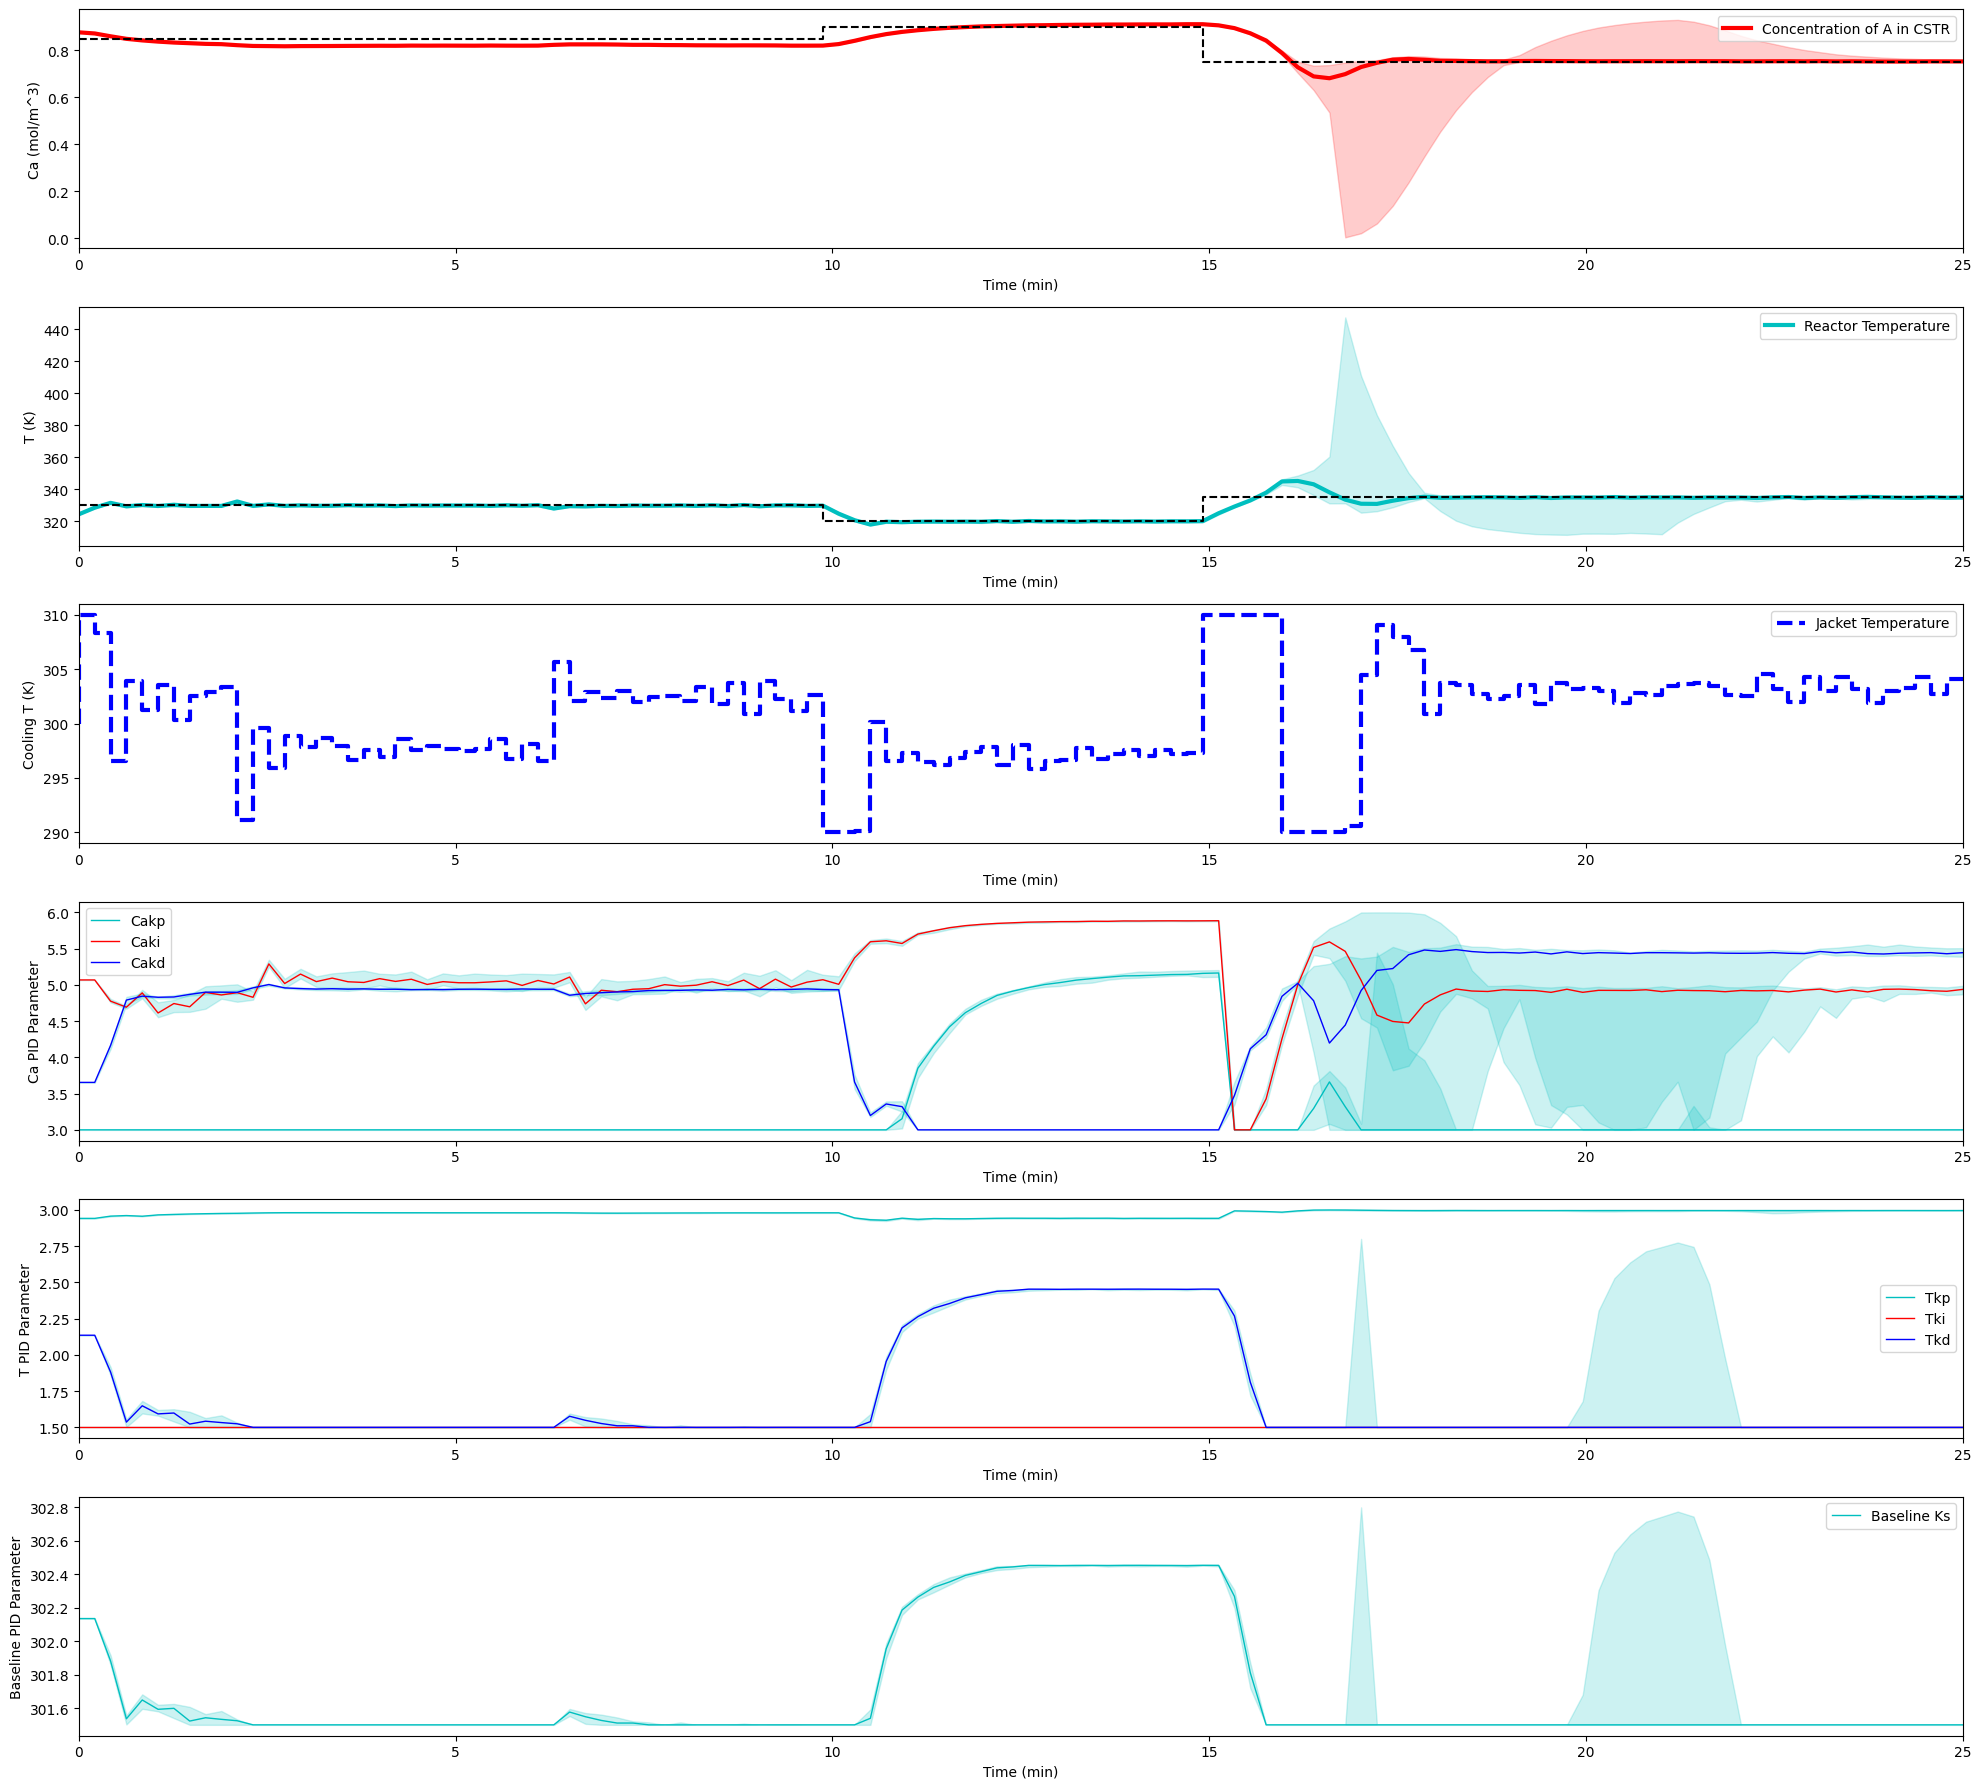

Text(0.5, 1.0, 'Learning Curve')

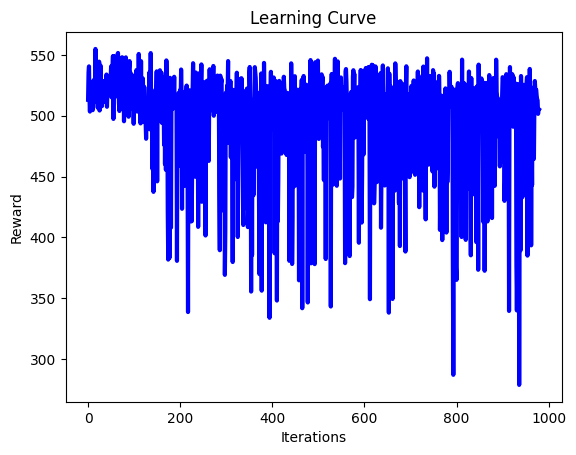

In [422]:
policy = Net(n_fc1 = 256,n_fc2 = 256,activation = torch.nn.ReLU,n_layers = 1 )
#Training Loop Parameters
k0     = 7.2e10 # Pre-exponential factor (1/sec)
UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
old_swarm  = 1e8
new_swarm = 0
tol = 0.01
ns = 120
Ca_des1 = [0.8 for i in range(int(ns/2))] + [0.9 for i in range(int(ns/2))]
T_des1  = [330 for i in range(int(ns/2))] + [320 for i in range(int(ns/2))]

Ca_des2 = [0.7 for i in range(int(ns/2))] + [0.9 for i in range(int(ns/2))]
T_des2  = [340 for i in range(int(ns/2))] + [320 for i in range(int(ns/2))]

Ca_des3 = [0.9 for i in range(int(ns/2))] + [0.8 for i in range(int(ns/2))]
T_des3  = [320 for i in range(int(ns/2))] + [330 for i in range(int(ns/2))]

Ca_des4 = [0.9 for i in range(int(ns/2))] + [0.7 for i in range(int(ns/2))]
T_des4  = [320 for i in range(int(ns/2))] + [340 for i in range(int(ns/2))]

Ca_disturb = [0.8 for i in range(ns)]
T_disturb = [330 for i in range(ns)]
SP = np.array(([Ca_des1,T_des1],[Ca_des2,T_des2],[Ca_des3,T_des3],[Ca_des4,T_des4],[Ca_disturb,T_disturb]),dtype = object)

max_iter = 30
policy_list = np.zeros(max_iter)
reward_list = np.zeros(max_iter)
old_swarm = np.zeros(max_iter)
best_reward = 1e8
i = 0
r_list = []
r_list_i =[]
p_list  =[]

evals_rs = 50

params = policy.state_dict()
#Random Search
print('Random search to find good initial policy...')
for policy_i in range(evals_rs):
    # sample a random policy
    NNparams_RS  = sample_uniform_params(params, 0.15, -0.15)
    # consruct policy to be evaluated
    policy.load_state_dict(NNparams_RS)
    # evaluate policy
    r = criterion(policy,SP,ns,k0,UA)
    #Store rewards and policies
    if r < best_reward:
        best_policy = p_list[r_list.index(r)]
        best_reward = r
        init_params= copy.deepcopy(NNparams_RS)
policy.load_state_dict(init_params)
#PSO Optimisation paramters
optim = ParticleSwarmOptimizer(policy.parameters(),
                               inertial_weight=0.5,
                               num_particles=30,
                               max_param_value=0.15,
                               min_param_value=-0.15)
print('Best reward after random search:', best_reward)
print('PSO Algorithm...')
while i < max_iter and abs(best_reward - old_swarm[i]) > tol :
    if i > 0:
      old_swarm[i] = min(r_list_i)
      del r_list_i[:]
    def closure():
        # Clear any grads from before the optimization step, since we will be changing the parameters
        optim.zero_grad()
        return criterion(policy,SP,ns,k0,UA)
    optim.step(closure)
    new_swarm = min(r_list_i)

    if new_swarm < best_reward:
      best_reward = new_swarm
      best_policy = p_list[r_list.index(new_swarm)]
      
      print('New best reward:', best_reward,'iteration:',i,'/',max_iter)
    i += 1
print('Finished optimisation')
print('Best reward:', best_reward)
print('Plotting Best Policy...')
#Plot results
reps = 10
ns = 120
Ca_eval = np.zeros((ns, reps))
T_eval = np.zeros((ns, reps))
Tc_eval = np.zeros((ns, reps))
ks_eval = np.zeros((7,ns,reps))

Ca_des_test = [0.85 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.75 for i in range(int(2*ns/5))]
T_des_test  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [335 for i in range(int(2*ns/5))]
SP = np.array([Ca_des_test,T_des_test])

for r_i in range(reps):
  data = Case_Study_1(0,cstr_CS1,best_policy,SP,ns,False,True,True,k0,UA) #Disturbance active
  Ca_eval[:,r_i] = data['Ca']
  T_eval[:,r_i] = data['T']
  Tc_eval[:,r_i] = data['u']
  ks_eval[:,:,r_i] = data['ks']
# Plot sim results
plot_simulation(Ca_eval, T_eval, Tc_eval,ks_eval,SP,ns)

# Plot training performance
plt.plot(list(r_list),'b',lw = 3)
plt.ylabel('Reward')
plt.xlabel('Iterations')
plt.title('Learning Curve')

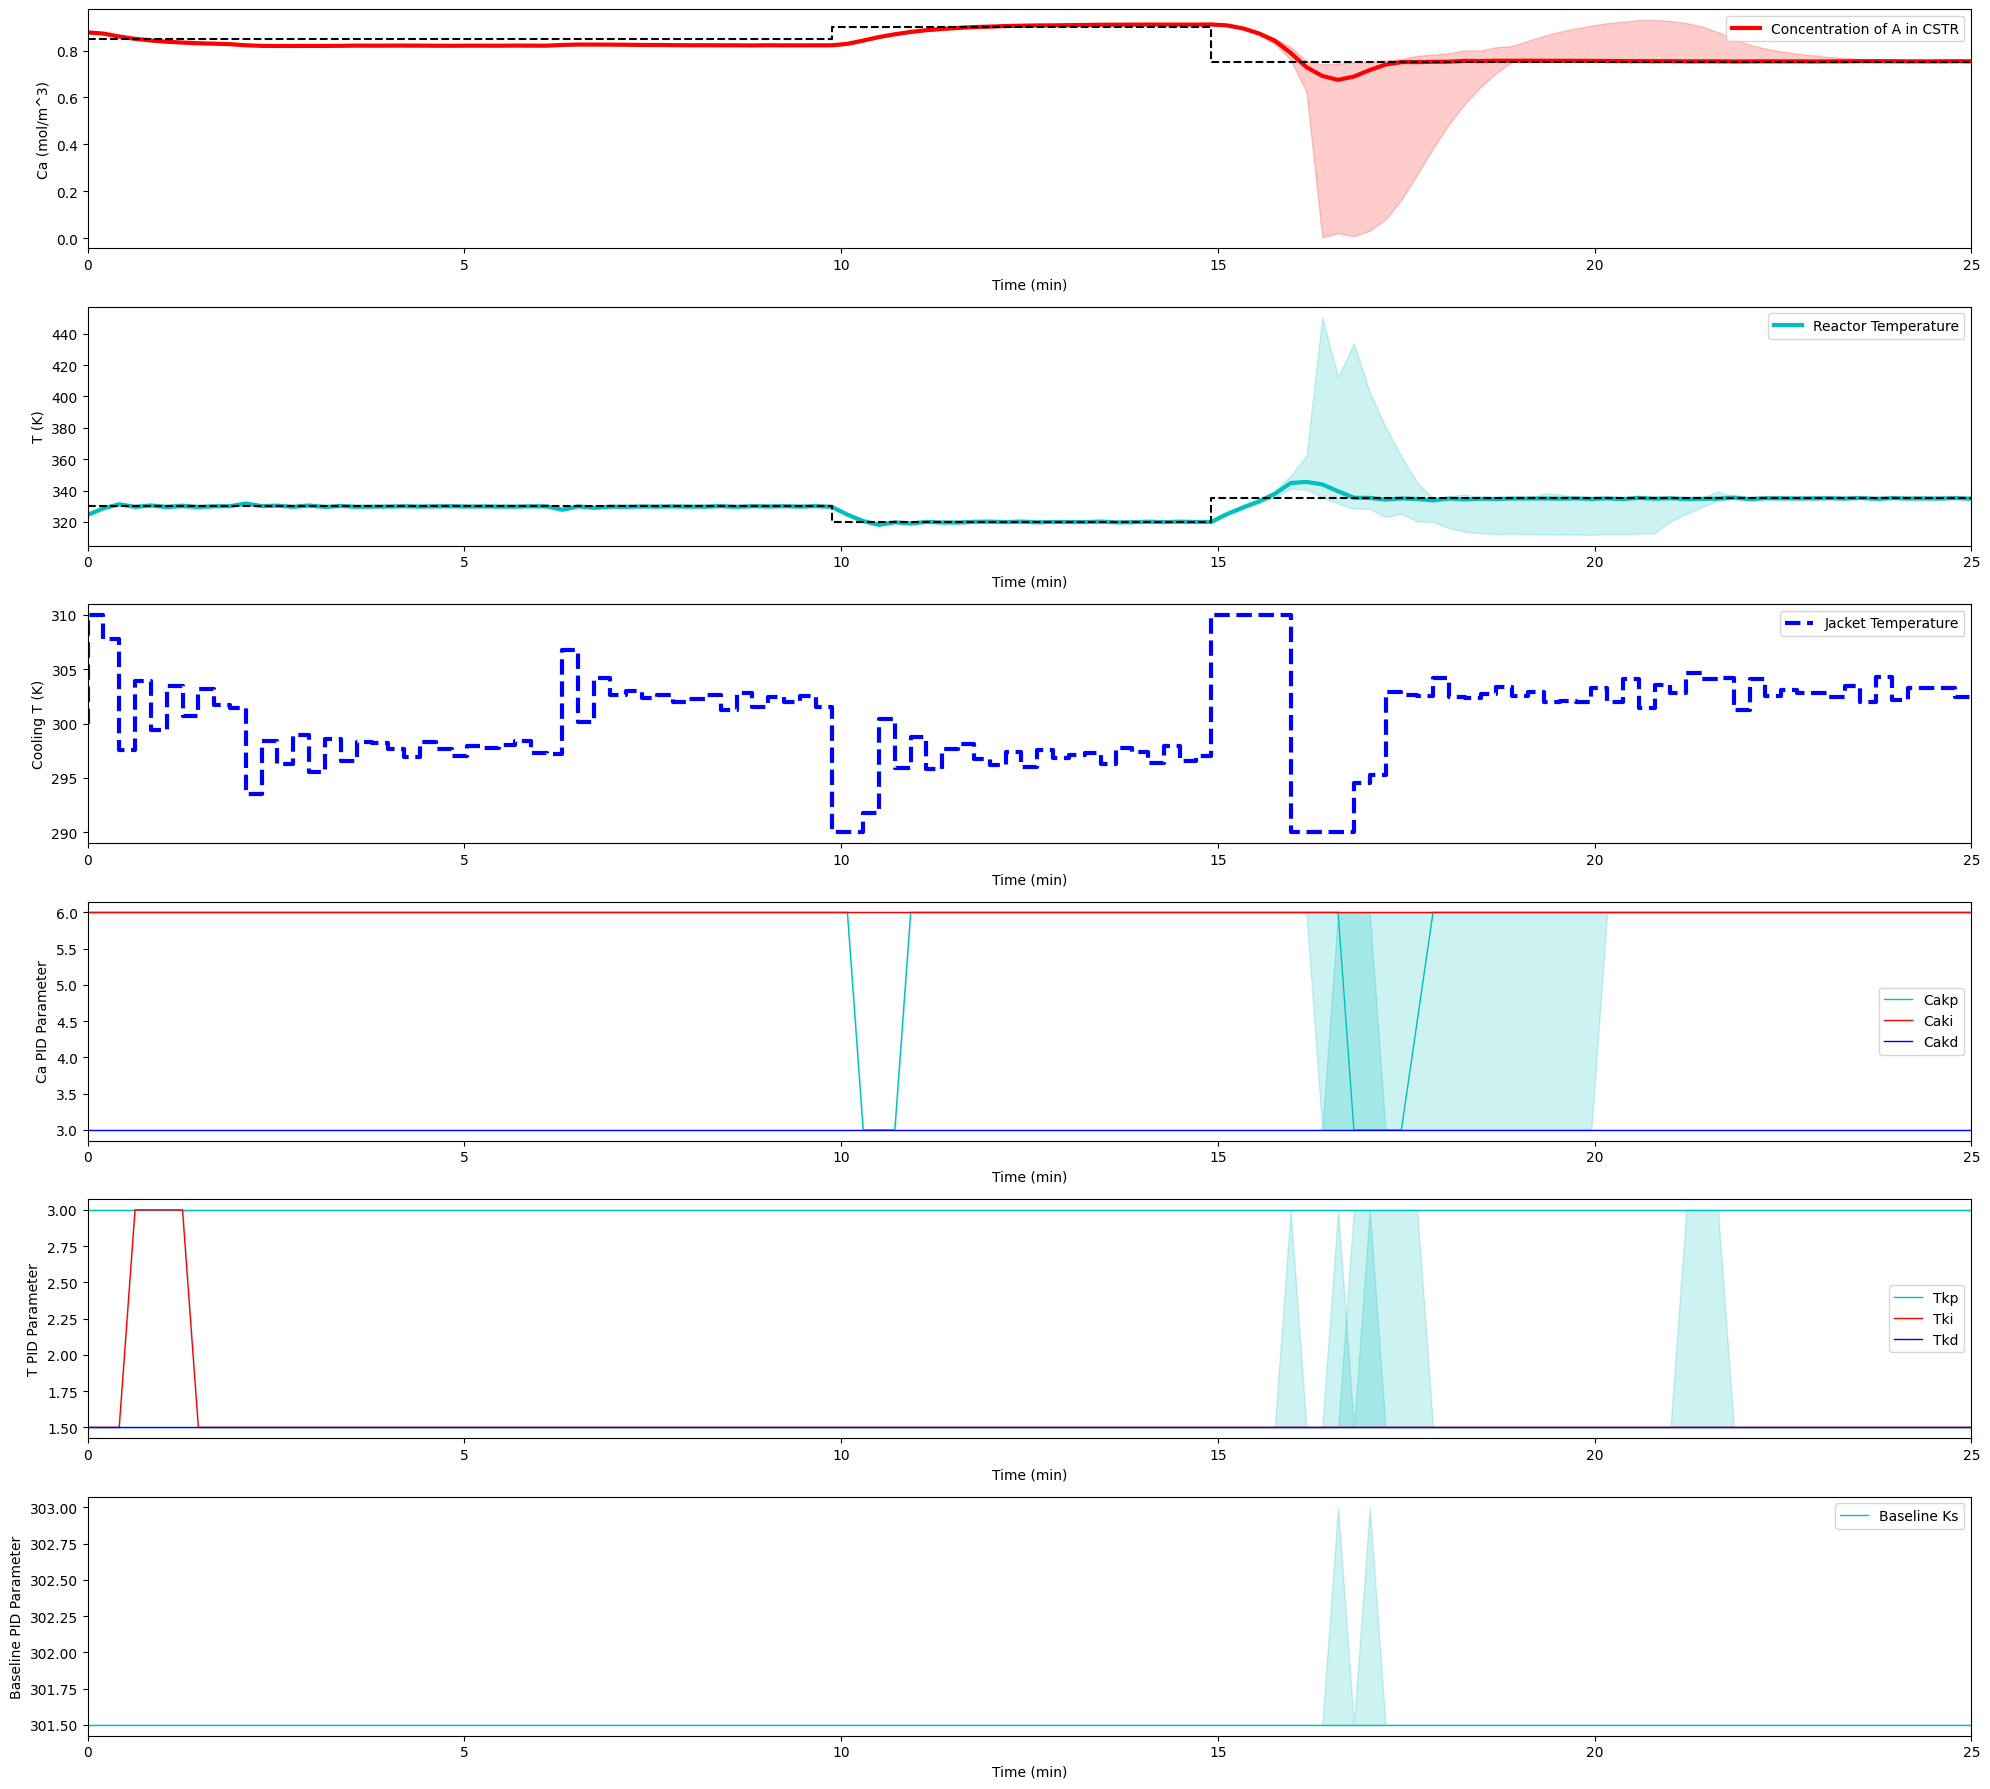

Text(0.5, 1.0, 'Learning Curve')

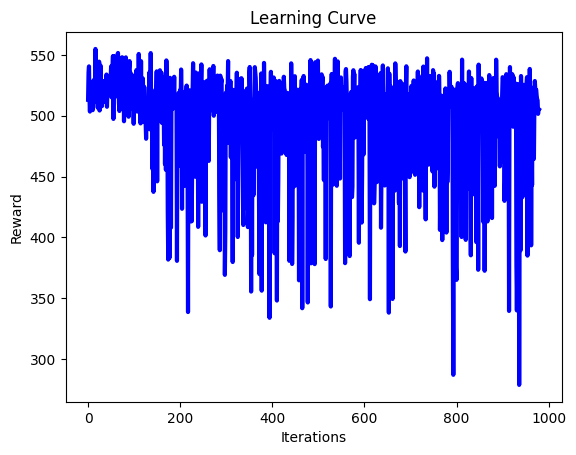

In [433]:
#Plot results
best_policy = Net(n_fc1 = 256,n_fc2 = 256,activation = torch.nn.ReLU,n_layers = 1 )

reps = 10
ns = 120
Ca_eval_EA = np.zeros((ns, reps))
T_eval_EA = np.zeros((ns, reps))
Tc_eval_EA = np.zeros((ns, reps))
ks_eval_EA = np.zeros((7,ns,reps))

Ca_des_test = [0.85 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.75 for i in range(int(2*ns/5))]
T_des_test  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [335 for i in range(int(2*ns/5))]
SP = np.array([Ca_des_test,T_des_test])

for r_i in range(reps):
  data = Case_Study_1(0,cstr_CS1,best_policy,SP,ns,False,True,True,k0,UA) #Disturbance active
  Ca_eval_EA[:,r_i] = data['Ca']
  T_eval_EA[:,r_i] = data['T']
  Tc_eval_EA[:,r_i] = data['u']
  ks_eval_EA[:,:,r_i] = data['ks']
# Plot sim results
plot_simulation(Ca_eval_EA, T_eval_EA, Tc_eval_EA,ks_eval_EA,SP,ns)

# Plot training performance
plt.plot(list(r_list),'b',lw = 3)
plt.ylabel('Reward')
plt.xlabel('Iterations')
plt.title('Learning Curve')

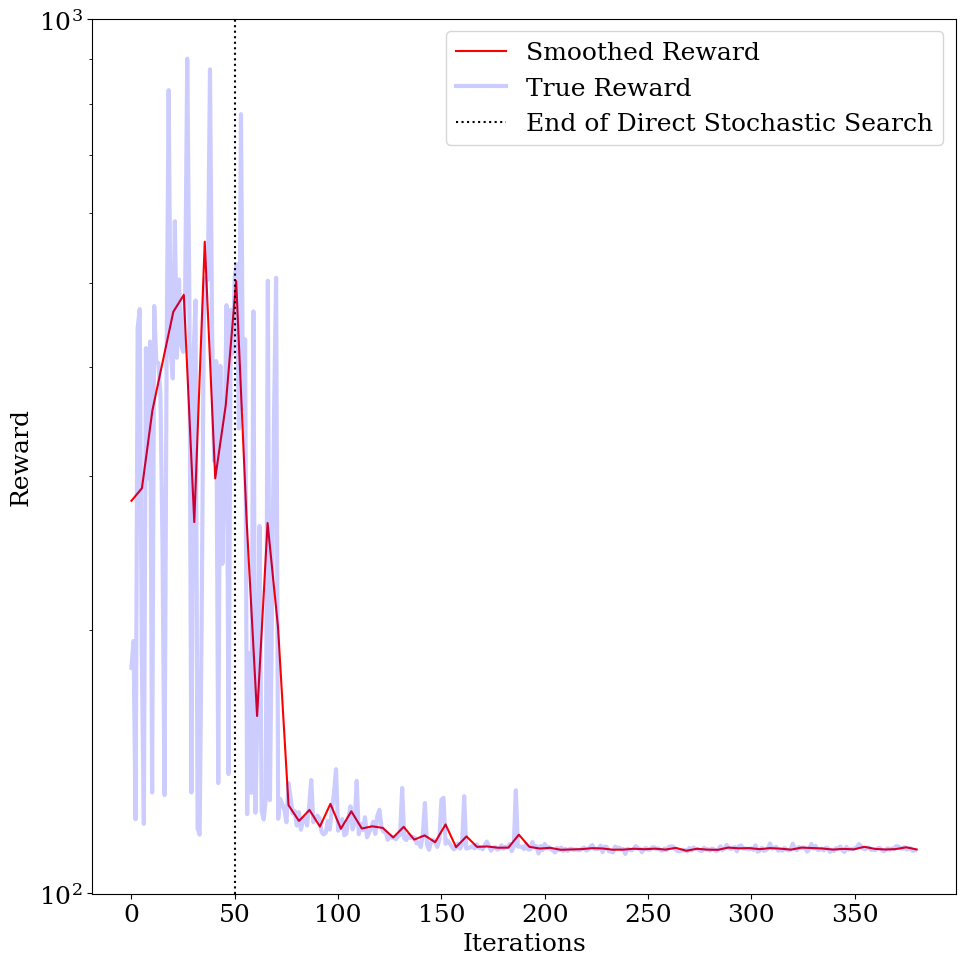

In [318]:
# Plot training performance
def average_5(lst):
    averages = []
    avg_every = 5
    for i in range(0, len(lst), avg_every):
        chunk = lst[i:i+avg_every]
        if len(chunk) == avg_every:
            avg = sum(chunk) / avg_every
            averages.append(avg)
    return averages

r_avg = average_5(r_list)
x = np.linspace(0,len(r_list),len(r_avg))
plt.figure(figsize=(10,10))
plt.plot(x,r_avg,'r', label = 'Smoothed Reward')
plt.plot(list(r_list),'b',lw = 3,alpha = 0.2, label =  'True Reward')
plt.axvline(x=evals_rs, linestyle = 'dotted', color = 'black',label = 'End of Direct Stochastic Search')
plt.yscale('log')
plt.ylabel('Reward')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('Learning_Curve_CS1.pdf')
plt.tight_layout()
plt.show()

In [352]:
learning_curve = np.array(r_list)
np.save('learning_curve_CS1.npy',learning_curve)

# PPO Policy 

In [202]:
# Create a gym environment
class reactor_class(gym.Env):
  def __init__(self,test = False):
    ns = 120 
    self.test = test
    Ca_des1 = [0.8 for i in range(int(ns/2))] + [0.9 for i in range(int(ns/2))]
    T_des1  = [330 for i in range(int(ns/2))] + [320 for i in range(int(ns/2))]

    Ca_des2 = [0.7 for i in range(int(ns/2))] + [0.9 for i in range(int(ns/2))]
    T_des2  = [340 for i in range(int(ns/2))] + [320 for i in range(int(ns/2))]

    Ca_des3 = [0.9 for i in range(int(ns/2))] + [0.8 for i in range(int(ns/2))]
    T_des3  = [320 for i in range(int(ns/2))] + [330 for i in range(int(ns/2))]

    Ca_des4 = [0.9 for i in range(int(ns/2))] + [0.7 for i in range(int(ns/2))]
    T_des4  = [320 for i in range(int(ns/2))] + [340 for i in range(int(ns/2))]
    if self.test:
      self.disturb = True
      Ca_des1 = [0.85 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.75 for i in range(int(2*ns/5))]
      T_des1  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [335 for i in range(int(2*ns/5))]
       
      
    
    self.observation_space = spaces.Box(low = np.array([.85, 326,.85, 326,0.85, 320]),high= np.array([0.95,346,0.95,346,0.95,340]))
    self.action_space = spaces.Box(low = np.array([0,0,0,0,0,0,0]),high= np.array([1]*7))


    Ca_disturb = [0.8 for i in range(ns)]
    T_disturb = [330 for i in range(ns)]
    
    self.SP = np.array(([Ca_des1,T_des1],[Ca_des2,T_des2],[Ca_des3,T_des3],[Ca_des4,T_des4],[Ca_disturb,T_disturb]),dtype = object)

    self.Ca_ss = 0.87725294608097
    self.T_ss  = 324.475443431599
    self.x0    = np.empty(2)
    self.x0[0] = self.Ca_ss
    self.x0[1] = self.T_ss
  
    self.u_ss = 300.0 # Steady State Initial Condition

    self.Caf  = 1     # Feed Concentration (mol/m^3)

    # Time Interval (min)
    self.t = np.linspace(0,25,ns)

    # Store results for plotting
    self.Ca = np.ones(len(self.t)) * self.Ca_ss
    self.T  = np.ones(len(self.t)) * self.T_ss
    self.u  = np.ones(len(self.t)) * self.u_ss
    self.Ks_list = np.zeros((7,len(self.t)))
    self.Tf = 350 # Feed Temperature (K)

  def reset(self, seed = None):
    self.i = 0
    self.SP_i = 0
    Ca_des = self.SP[self.SP_i,0][self.i]
    T_des = self.SP[self.SP_i,1][self.i] 
    self.state = np.array([self.Ca_ss,self.T_ss,self.Ca_ss,self.T_ss,Ca_des,T_des])
    self.done = False
    self.disturb = False
    self.u_history = []
    self.e_history = []
    self.ts      = [self.t[self.i],self.t[self.i+1]]
    self.state_norm = (self.state -self.observation_space.low)/(self.observation_space.high - self.observation_space.low)
    return self.state_norm,{}

  def step(self, action_policy):
    self.action = action_policy
    Ca_des = self.SP[self.SP_i,0][self.i]
    T_des = self.SP[self.SP_i,1][self.i]   
    self.state,rew = self.reactor(self.state,self.action,Ca_des,T_des)
    self.i += 1
    if self.i == 120:
        if self.SP_i < 4:
          self.SP_i += 1
          self.i = 0
          self.state = np.array([self.Ca_ss,self.T_ss,self.Ca_ss,self.T_ss,Ca_des,T_des])
          self.u_history = []
          self.e_history = []
          if self.SP_i == 4:
            self.disturb = True
        else:
          self.done = True
        
    

    
    self.state_norm = (self.state -self.observation_space.low)/(self.observation_space.high - self.observation_space.low)
    return self.state_norm,rew,self.done,False,{}

  def reactor(self,state,action,Ca_des,T_des):
   
    k0 = 7.2e10 #1/sec
    UA = 5e4 # W/K
    # Steady State Initial Conditions for the States

    Ca = state[0]
    T  = state[1]

    if self.disturb and self.i > 10 and self.i < 30:
      self.Tf = 360  
   
    x_sp    = np.array([Ca_des,T_des])
    
 
    Ks = action #Ca, T, u, Ca setpoint and T setpoint
    #Adjust bounds from relu

    for ks_i in range(0,3):
        Ks[ks_i] = (Ks[ks_i])*6
        
    for ks_i in range(3,6):
        Ks[ks_i] = (Ks[ks_i])*3
       
    Ks[6] = (Ks[ks_i]) + 300

    if self.i == 0:
        u  = PID(Ks, state[0:2], x_sp, np.array([[0,0]]))
    else:
        u  = PID(Ks,state[0:2], x_sp, np.array(self.e_history))
    # simulate system
    y       = odeint(cstr_CS1,state[0:2],self.ts,args=(u,self.Tf,self.Caf,k0,UA))

    # add process disturbance
    Ca_plus = y[-1][0] + np.random.uniform(low=-0.001,high=0.001)
    T_plus  = y[-1][1] + np.random.uniform(low=-.5,high=0.5)
    # collect data
    state_plus = np.zeros(6)
    state_plus[0]   = Ca_plus
    state_plus[1]   = T_plus
    state_plus[2]   = Ca
    state_plus[3]   = T
    state_plus[4]   = Ca_des
    state_plus[5]   = T_des
    # compute tracking error
    e  = x_sp-state_plus[0:2]
    self.e_history.append((x_sp-state_plus[0:2]))
    #Penalise control action magnitude
    u_mag = np.abs(np.array(u-295))/10 #250 is lower bound of jacket temperature
    u_mag = u_mag/10
    # penalise change in control action
    if self.i == 0:
      u_cha = 0
    else:
      u_cha = np.abs(u-self.u_history[-1])/100
    
   
    self.u_history.append(u)
    #Compute reward (squared distance + scaled)
  
    r_x = np.abs(e[0])/0.2+np.abs(e[1])/15 + u_mag + u_cha
    
    return state_plus, -r_x
    

    

Change the policy used in SB3 to the same as the EA method

In [236]:
env = reactor_class()

model = SAC("MlpPolicy", env, verbose=1,learning_rate=0.001).learn(3e4)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 600      |
|    ep_rew_mean     | -504     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 79       |
|    time_elapsed    | 30       |
|    total_timesteps | 2400     |
| train/             |          |
|    actor_loss      | -7.5     |
|    critic_loss     | 1.85     |
|    ent_coef        | 0.113    |
|    ent_coef_loss   | -17.2    |
|    learning_rate   | 0.001    |
|    n_updates       | 2299     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 600      |
|    ep_rew_mean     | -411     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 73       |
|    time_elapsed    | 65       |
|    total_timesteps | 4800     |
| train/             

In [365]:
ks_eval_EA

array([[[7.65438450e+06, 7.65438450e+06, 7.65438450e+06, ...,
         7.65438450e+06, 7.65438450e+06, 7.65438450e+06],
        [7.65438450e+06, 7.65438450e+06, 7.65438450e+06, ...,
         7.65438450e+06, 7.65438450e+06, 7.65438450e+06],
        [1.14637200e+07, 1.16783190e+07, 1.13398170e+07, ...,
         1.26098500e+07, 1.18357890e+07, 1.13028630e+07],
        ...,
        [1.13412238e+06, 8.81757875e+05, 1.02859190e+07, ...,
         7.06062150e+06, 1.22885712e+06, 2.34704775e+06],
        [5.19551500e+06, 7.13237200e+06, 3.63286575e+06, ...,
         8.03475300e+06, 6.83912000e+06, 9.19040200e+06],
        [9.46454200e+06, 8.68109400e+06, 1.03376560e+07, ...,
         1.45012662e+06, 9.33127200e+06, 1.11957762e+06]],

       [[3.48904320e+07, 3.48904320e+07, 3.48904320e+07, ...,
         3.48904320e+07, 3.48904320e+07, 3.48904320e+07],
        [3.48904320e+07, 3.48904320e+07, 3.48904320e+07, ...,
         3.48904320e+07, 3.48904320e+07, 3.48904320e+07],
        [3.47707960e+07, 

In [12]:
PPO_policy.save('PID_SAC_3101')

In [313]:
env = reactor_class(test = True)
ns = 120
Ca_des = [0.85 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.75 for i in range(int(2*ns/5))]
T_des  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [335 for i in range(int(2*ns/5))]
reps = 10
Ca_eval_PG = np.zeros((ns,reps))
T_eval_PG = np.zeros((ns,reps))
Tc_eval_PG = np.zeros((ns,reps))
ks_eval_PG = np.zeros((7,ns,reps))

SP = np.array([Ca_des,T_des])
for r_i in range(reps):
  s_norm,_ = env.reset()
  s = s_norm*(env.observation_space.high - env.observation_space.low) + env.observation_space.low
  Ca_eval_PG[0,r_i] = s[0]
  T_eval_PG[0,r_i] = s[1]
  Tc_eval_PG[0,r_i] = 300.0
  a_norm, _states = model.predict(s_norm)
  a = a_norm
  for ks_i in range(0,3):
      a[ks_i] = (a[ks_i])*6
      
  for ks_i in range(3,6):
      a[ks_i] = (a[ks_i])*3
       
  a[6] = (a[ks_i]) + 300
  ks_eval_PG[:,0,r_i] = a
  r_tot = 0
  for i in range(1,120):
    a_norm, _states = model.predict(s_norm)
    a = a_norm
    for ks_i in range(0,3):
        a[ks_i] = (a[ks_i])*6
        
    for ks_i in range(3,6):
        a[ks_i] = (a[ks_i])*3
       
    a[6] = (a[ks_i]) + 300
    ks_eval_PG[:,i,r_i] = a
    
    s_norm, r, done, info,_ = env.step(a_norm)
    r_tot += r
    s = s_norm*(env.observation_space.high - env.observation_space.low) + env.observation_space.low
    Ca_eval_PG[i,r_i] = s[0]
    T_eval_PG[i,r_i] = s[1]
    
    Tc_eval_PG[i,r_i] = env.u_history[-1]

    

plot_simulation(Ca_eval_PG, T_eval_PG, Tc_eval_PG,ks_eval_PG,SP,ns)

TypeError: plot_simulation() missing 4 required positional arguments: 'Tc_dat_EA', 'ks_eval_EA', 'SP', and 'ns'

In [314]:
ks_eval_PG[6,:,:] 

array([[302.1293335 , 302.56018066, 302.04406738, ..., 302.25796509,
        302.25979614, 301.78234863],
       [302.24520874, 302.24255371, 302.11245728, ..., 302.19247437,
        301.86889648, 302.20880127],
       [301.97674561, 301.59216309, 301.06842041, ..., 302.15240479,
        301.88214111, 301.97640991],
       ...,
       [300.90563965, 300.92358398, 300.90567017, ..., 300.91934204,
        301.14489746, 301.24990845],
       [301.13916016, 301.04855347, 301.19760132, ..., 301.01358032,
        300.46243286, 301.37176514],
       [301.043396  , 300.80657959, 300.98544312, ..., 301.32824707,
        300.62097168, 300.72140503]])

# Comparison of EA and PG Algs

In [363]:
def plot_simulation_comp(Ca_dat_PG, T_dat_PG, Tc_dat_PG,ks_eval_PG,Ca_dat_EA, T_dat_EA, Tc_dat_EA,ks_eval_EA,SP,ns):
    Ca_des = SP[0]
    T_des  = SP[1]
    t = np.linspace(0,25,ns)

    plt.figure(figsize=(10, 18))
        
    plt.subplot(9,1,1)
    plt.plot(t, np.median(Ca_dat_PG,axis=1), 'r-', lw=1, label = 'PG')
    plt.plot(t, np.median(Ca_dat_EA,axis=1), 'b-', lw=1, label = 'EA')
    plt.gca().fill_between(t, np.min(Ca_dat_PG,axis=1), np.max(Ca_dat_PG,axis=1),color='r', alpha=0.2)
    plt.gca().fill_between(t, np.min(Ca_dat_EA,axis=1), np.max(Ca_dat_EA,axis=1),color='b', alpha=0.2)
                           
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(9,1,2)
    plt.plot(t, np.median(T_dat_PG,axis=1), 'r-', lw=1, label = 'PG')
    plt.plot(t, np.median(T_dat_EA,axis=1), 'b-', lw=1, label = 'EA')
    plt.gca().fill_between(t, np.min(T_dat_PG,axis=1), np.max(T_dat_PG,axis=1),color='r', alpha=0.2)
    plt.gca().fill_between(t, np.min(T_dat_EA,axis=1), np.max(T_dat_EA,axis=1),color='b', alpha=0.2)
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(9,1,3)
    plt.step(t, np.median(Tc_dat_PG,axis=1), 'r--', lw=1, label = 'PG')
    plt.step(t, np.median(Tc_dat_EA,axis=1), 'b--', lw=1, label = 'EA')
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    labels = ['Cakp','Caki','Cakd','Tkp','Tki','Tkd']
    col = ['c-','r-','b-','c-','r-','b-']
    col_fill = ['c','r','b','c','r','b']
    plt.subplot(9,1,4)
    plt.title('EA PID Parameters')
    for ks_i in range(3):
      plt.plot(t, np.median(ks_eval_EA[ks_i,:,:],axis=1), col[ks_i], lw=1,label = labels[ks_i])
      plt.gca().fill_between(t, np.min(ks_eval_EA[ks_i,:,:],axis=1), np.max(ks_eval_EA[ks_i,:,:],axis=1),
                              color=col_fill[ks_i], alpha=0.2)
    plt.ylabel('Ca PID Parameter (EA)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(9,1,5)
    i = [3,4,5]
    for ks_i in i:
      plt.plot(t, np.median(ks_eval_EA[ks_i,:,:],axis=1), col[ks_i], lw=1,label = labels[ks_i])
      plt.gca().fill_between(t, np.min(ks_eval_EA[ks_i,:,:],axis=1), np.max(ks_eval_EA[ks_i,:,:],axis=1),
                              color=col_fill[ks_i], alpha=0.2)
    plt.ylabel('T PID Parameter (EA)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(9,1,6)
    plt.plot(t, np.median(ks_eval_EA[6,:,:],axis=1), 'c-', lw=1,label = 'Baseline Ks')
    plt.gca().fill_between(t, np.min(ks_eval_EA[6,:,:],axis=1), np.max(ks_eval_EA[6,:,:],axis=1),
                              color='c', alpha=0.2)
    plt.ylabel('Baseline PID Parameter (EA)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))
    
    plt.subplot(9,1,7)
    plt.title('PG PID Parameters')
    for ks_i in range(3):
      plt.plot(t, np.median(ks_eval_PG[ks_i,:,:],axis=1), col[ks_i], lw=1,label = labels[ks_i])
      plt.gca().fill_between(t, np.min(ks_eval_PG[ks_i,:,:],axis=1), np.max(ks_eval_PG[ks_i,:,:],axis=1),
                              color=col_fill[ks_i], alpha=0.2)
    plt.ylabel('Ca PID Parameter (EA)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(9,1,8)
    i = [3,4,5]
    for ks_i in i:
      plt.plot(t, np.median(ks_eval_PG[ks_i,:,:],axis=1), col[ks_i], lw=1,label = labels[ks_i])
      plt.gca().fill_between(t, np.min(ks_eval_PG[ks_i,:,:],axis=1), np.max(ks_eval_PG[ks_i,:,:],axis=1),
                              color=col_fill[ks_i], alpha=0.2)
    plt.ylabel('T PID Parameter (PG)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(9,1,9)
    plt.plot(t, np.median(ks_eval_PG[6,:,:],axis=1), 'c-', lw=1,label = 'Baseline Ks')
    plt.gca().fill_between(t, np.min(ks_eval_PG[6,:,:],axis=1), np.max(ks_eval_PG[6,:,:],axis=1),
                              color='c', alpha=0.2)
    plt.ylabel('Baseline PID Parameter (PG)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.tight_layout()
    plt.show()

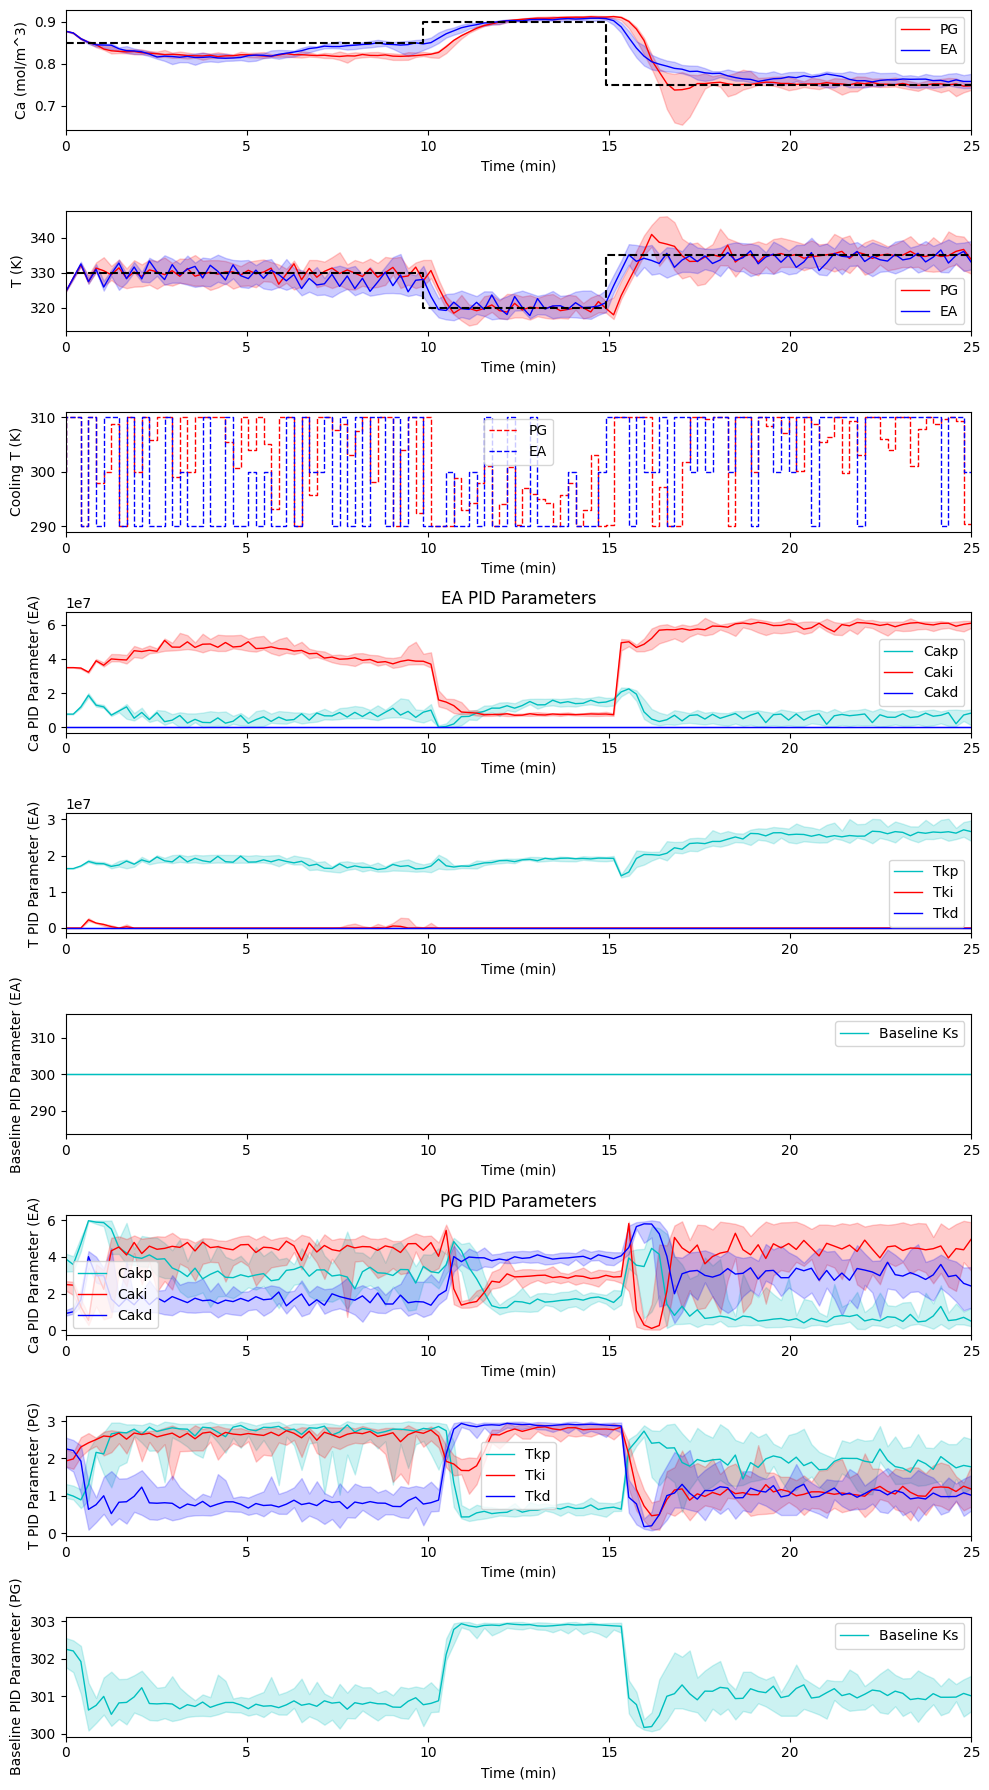

Ca-IAE for PG Alg: 6.734825574869688
T-IAE for PG Alg: 504.5698926499881
Ca-IAE for EA Alg: 6.6593577103678685
T-IAE for EA Alg: 485.16580724899814


In [364]:
plot_simulation_comp(Ca_eval_PG, T_eval_PG, Tc_eval_PG,ks_eval_PG,Ca_eval_EA, T_eval_EA, Tc_eval_EA,ks_eval_EA,SP,ns)
print('Ca-IAE for PG Alg:',np.abs(SP[0]-np.median(Ca_eval_PG)).sum())
print('T-IAE for PG Alg:',np.abs(SP[1]-np.median(T_eval_PG)).sum())
print('Ca-IAE for EA Alg:',np.abs(SP[0]-np.median(Ca_eval_EA)).sum())
print('T-IAE for EA Alg:',np.abs(SP[1]-np.median(T_eval_EA)).sum())

# Save the model

In [353]:
torch.save(best_policy.state_dict(),'CS1.pth')
policy.load_state_dict(torch.load('CS1.pth'))

<All keys matched successfully>

# DFO 

In [10]:
def Random_search(f, n_p, bounds_rs, iter_rs,SP,ns):
    '''
    This function is a naive optimization routine that randomly samples the
    allowed space and returns the best value.

    This is used to find a good starting point for Powell
    '''

    # arrays to store sampled points
    localx   = np.zeros((n_p,iter_rs))  # points sampled
    localval = np.zeros((iter_rs))        # function values sampled
    # bounds
    bounds_range = bounds_rs[:,1] - bounds_rs[:,0]
    bounds_bias  = bounds_rs[:,0]

    for sample_i in range(iter_rs):
        x_trial = np.random.uniform(0, 1, n_p)*bounds_range + bounds_bias # sampling
        localx[:,sample_i] = x_trial
        localval[sample_i] = f(x_trial,cstr_CS1,1,SP,ns,True,False,True,k0,UA) # f
    # choosing the best
    minindex = np.argmin(localval)
    f_b      = localval[minindex]
    x_b      = localx[:,minindex]

    return f_b,x_b

#########################
# --- Powell Method --- #
#########################

# (f, N_x: int, bounds: array[array[float]], N: int = 100) -> array(N_X), float
def opt_Powell(f, x_dim, bounds, iter_tot,SP,ns):
    '''
    params: parameters that define the rbf model
    X:      matrix of previous datapoints
    '''

    n_rs = int(min(100,max(iter_tot*.05,5)))       # iterations to find good starting point

    # evaluate first point
    f_best, x_best = Random_search(f, x_dim, bounds, n_rs,SP,ns)
    iter_          = iter_tot - n_rs

    opt = minimize(f, x_best,args = (cstr_CS1,1,SP,ns,True,False,True,k0,UA), bounds=bounds, method='Powell',
                   options={'maxfev': iter_})
    print('PID tuning results')
    print(opt)

    return opt.x, opt.fun

PID tuning results
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 26.300993463017047
       x: [ 2.891e+00  1.910e+00  3.013e+00  3.090e+00  7.489e-01
            3.082e+00  2.971e+02]
     nit: 1
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 130


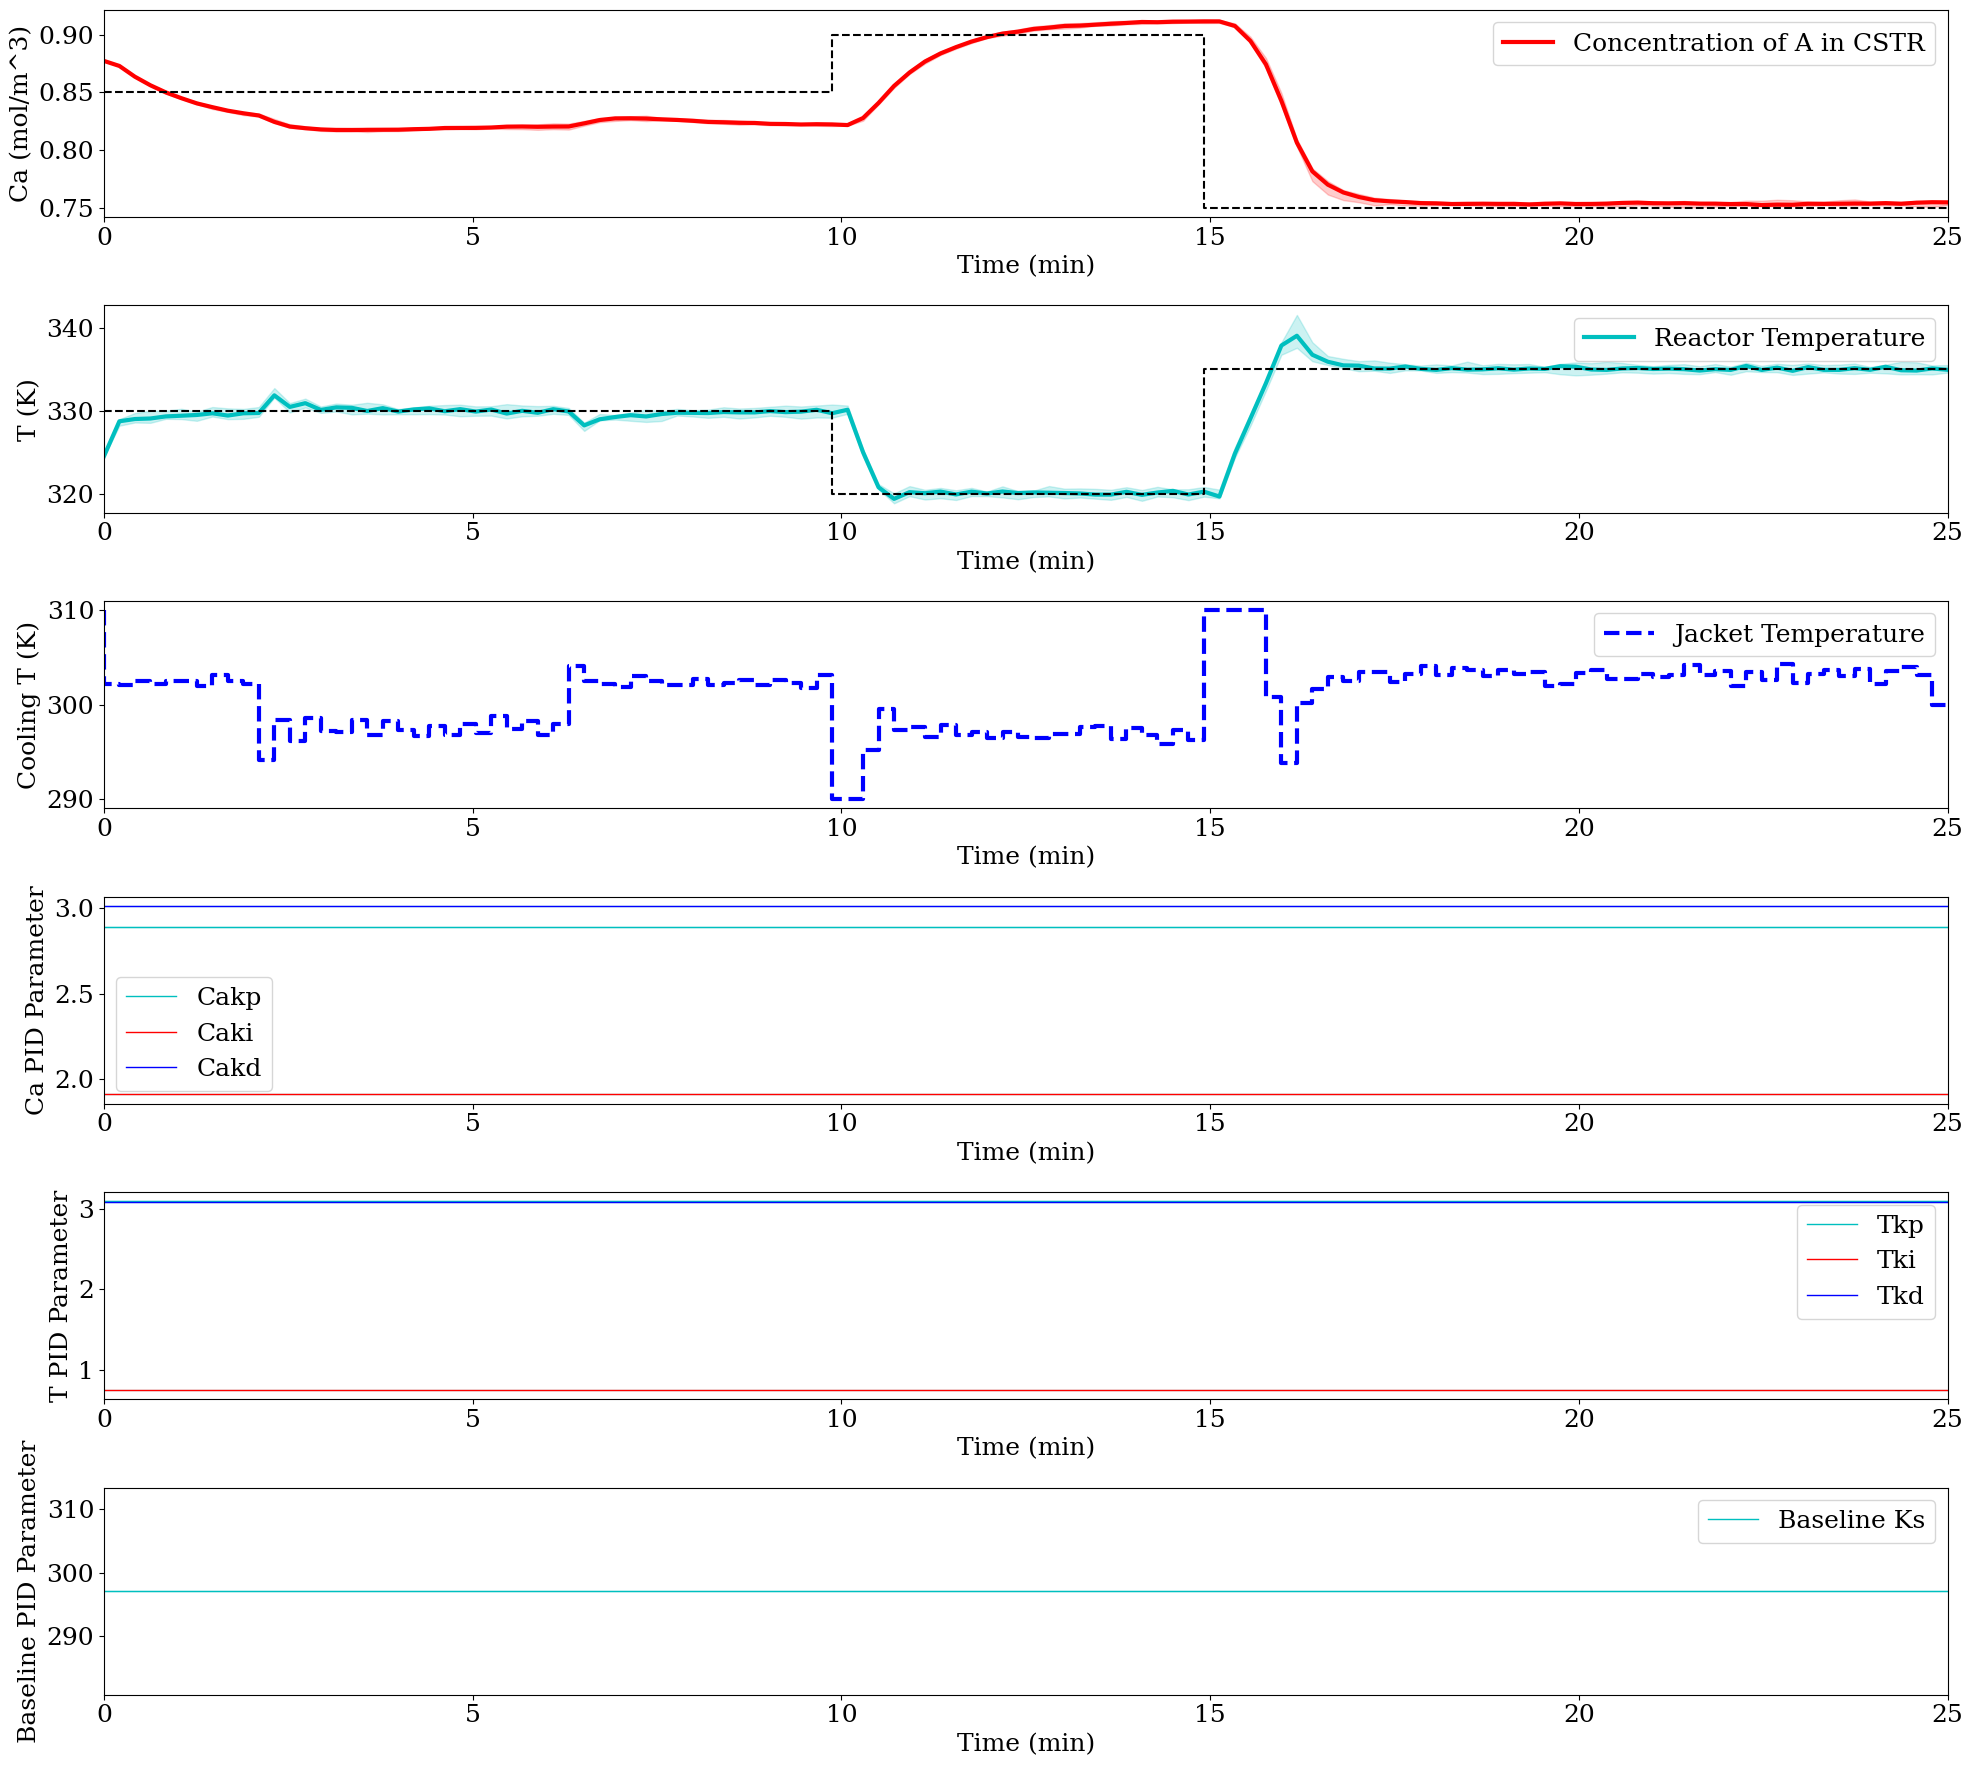

0.43205538287389544
3600.689454202018


In [191]:
#Optimise PID parameters over whole time period for Case Study 1
#Optimiser Parameters
ns = 120
# Ca_des_test = [0.8 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.8 for i in range(int(2*ns/5))]
# T_des_test  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [330 for i in range(int(2*ns/5))]
Ca_des_test = [0.85 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.75 for i in range(int(2*ns/5))]
T_des_test  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [335 for i in range(int(2*ns/5))]
SP_test = np.array([Ca_des_test,T_des_test])
iter_tot = 1000
boundsKs = np.array([[0,5]]*6+[[280,300]])
k0     = 7.2e10 # Pre-exponential factor (1/sec)
UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
#Call optimiser
Ks_opt, f_opt = opt_Powell(Case_Study_1, 7, boundsKs, iter_tot, SP_test,ns)
t = np.linspace(0,25,ns)
reps = 10
Ca_ks_eval = np.zeros((ns,reps))
T_ks_eval = np.zeros((ns,reps))
Tc_ks_eval = np.zeros((ns,reps))
ks_ks_evals = np.tile(Ks_opt,(reps,ns,7)).T
for r_i in range(reps):
  data_KsOpt = Case_Study_1(Ks_opt,cstr_CS1,1,SP_test,ns,True,True,True,k0,UA)
  Ca_ks_eval[:,r_i] = data_KsOpt['Ca']
  T_ks_eval[:,r_i] = data_KsOpt['T']
  Tc_ks_eval[:,r_i] = data_KsOpt['u']

plot_simulation(Ca_ks_eval, T_ks_eval, Tc_ks_eval,ks_ks_evals,SP,ns)
#Simulate with optimised PID parameters
print(np.sum((np.median(Ca_ks_eval)-Ca_des_test)**2))
print(np.sum((np.median(T_ks_eval)-T_des_test)**2))

# Relay

In [12]:
def PID_relay(Ks, x, x_setpoint, e_history):

    # K gains
    KpCa = Ks[0]; KiCa = Ks[1]; KdCa = Ks[2]
    KpT  = Ks[3]; KiT  = Ks[4]; KdT  = Ks[5]; Kb = Ks[6]
    # setpoint error

    e = x_setpoint - x
    # if Ks[0] == 0 and Ks[1] == 0 and Ks[2] == 0:
    #   e = x - x_setpoint
    # control action

    u = KpCa*e[0] + KiCa*sum(e_history[:,0]) + KdCa*(e[0]-e_history[-1,0])
    u += KpT *e[1] + KiT *sum(e_history[:,1]) + KdT *(e[1]-e_history[-1,1])
    u += Kb
    u = min(max(u,290),310)


    return u

In [13]:
def OnOffController_Tj(e):
  if e < 0:
    Tj = 310
  else:
    Tj = 290
  return Tj

In [14]:
def Case_Study_1_OnOff(SP,ns):
    # Steady State Initial Conditions for the States
    Ca_ss = 0.87725294608097
    T_ss  = 324.475443431599
    x0    = np.empty(2)
    x0[0] = Ca_ss
    x0[1] = T_ss

    # desired steady states
    Ca_des = SP[0]
    T_des  = SP[1]

    u_ss = 310.0 # Steady State Initial Condition
    Caf  = 1     # Feed Concentration (mol/m^3)

    # Time Interval (min)
    t = np.linspace(0,25,ns)

    # Store results for plotting
    Ca = np.ones(len(t)) * Ca_ss
    T  = np.ones(len(t)) * T_ss
    u  = np.ones(len(t)) * u_ss

    Tf = 350 # Feed Temperature (K)



    for i in range(len(t)-1):
        # delta t
        ts      = [t[i],t[i+1]]
        # desired setpoint
        # compute control
        e_ca = Ca_des[i] - x0[0]
        if abs(e_ca) > 0.001:
          u[i] = OnOffController_Tj(e_ca)
        else:
          u[i] = u[i-1]

        # simulate system
        y       = odeint(cstr_CS1,x0,ts,args=(u[i],Tf,Caf,k0,UA))
        # add process disturbance
        Ca[i+1] = y[-1][0] + np.random.uniform(low=-0.001,high=0.001)
        T[i+1]  = y[-1][1] + np.random.uniform(low=-.5,high=0.5)
        # collect data
        x0[0]   = Ca[i+1]
        x0[1]   = T[i+1]


    data= {}
    data['t'] = t
    data['u'] = u
    data['Ca'] = Ca
    data['T'] = T
    data['Ca_des'] = Ca_des
    data['T_des'] = T_des
    return data

In [15]:
def relay_tune(loop,model):
  '''
  Determine PID parameters via the relay tuning method developed by Astrom and Haggland (1984)

  '''

  # == Generate Data == #
  ns = 120
  reps = 10
  Ca_des = [0.8 for i in range(ns)] #+ [0.95 for i in range(51)]
  T_des  = [330 for i in range(ns)]
  SP = np.array([Ca_des,T_des])

  Ca_dat = np.zeros((ns,reps))
  T_dat = np.zeros((ns,reps))
  Tc_dat = np.zeros((ns,reps))

  for r_i in range(reps):
    data = model(SP,ns)
    Ca_dat[:,r_i] = data['Ca']
    T_dat[:,r_i] = data['T']
    Tc_dat[:,r_i] = data['u']

  # == Find peaks and troughs == #
  if loop == 'T':
    peaks, _ = find_peaks(T_dat[:,0], height=0)
    troughs, _= find_peaks(-T_dat[:,0])
  elif loop == 'Ca':
    peaks, _ = find_peaks(Ca_dat[:,0], height=0)
    troughs, _= find_peaks(-Ca_dat[:,0])

  # == Find PID Parameters
  # == Pu ==#
  PU = np.zeros(peaks.shape[0])
  for i in range(peaks.shape[0]-1):
    PU[i]= peaks[i+1]-peaks[i]
  PU = np.trim_zeros(PU)
  Pu_mean = np.mean(PU)

  # == a == #
  a = np.zeros(peaks.shape[0])
  if loop == 'T':
    for i in range(peaks.shape[0]-1):
      a[i]= T_dat[peaks[i],0] - T_dat[troughs[i],0]

  if loop == 'Ca':
    for i in range(peaks.shape[0]-1):
      a[i]= Ca_dat[peaks[i],0] - Ca_dat[troughs[i],0]
  a = np.trim_zeros(a)
  a_mean = abs(np.mean(a))

  # == d == #
  d = (max(Tc_dat[:,0]) - min(Tc_dat[:,0]))/2

  # == Ku == #
  Ku = (4*d)/(a_mean * np.pi)

  # == PID Parameters == #
  kc = 0.6*Ku
  tauI = 0.5*Ku/Pu_mean
  tauD = 0.075*Ku*Pu_mean
  ks = np.array([kc,tauI,tauD])

  return ks

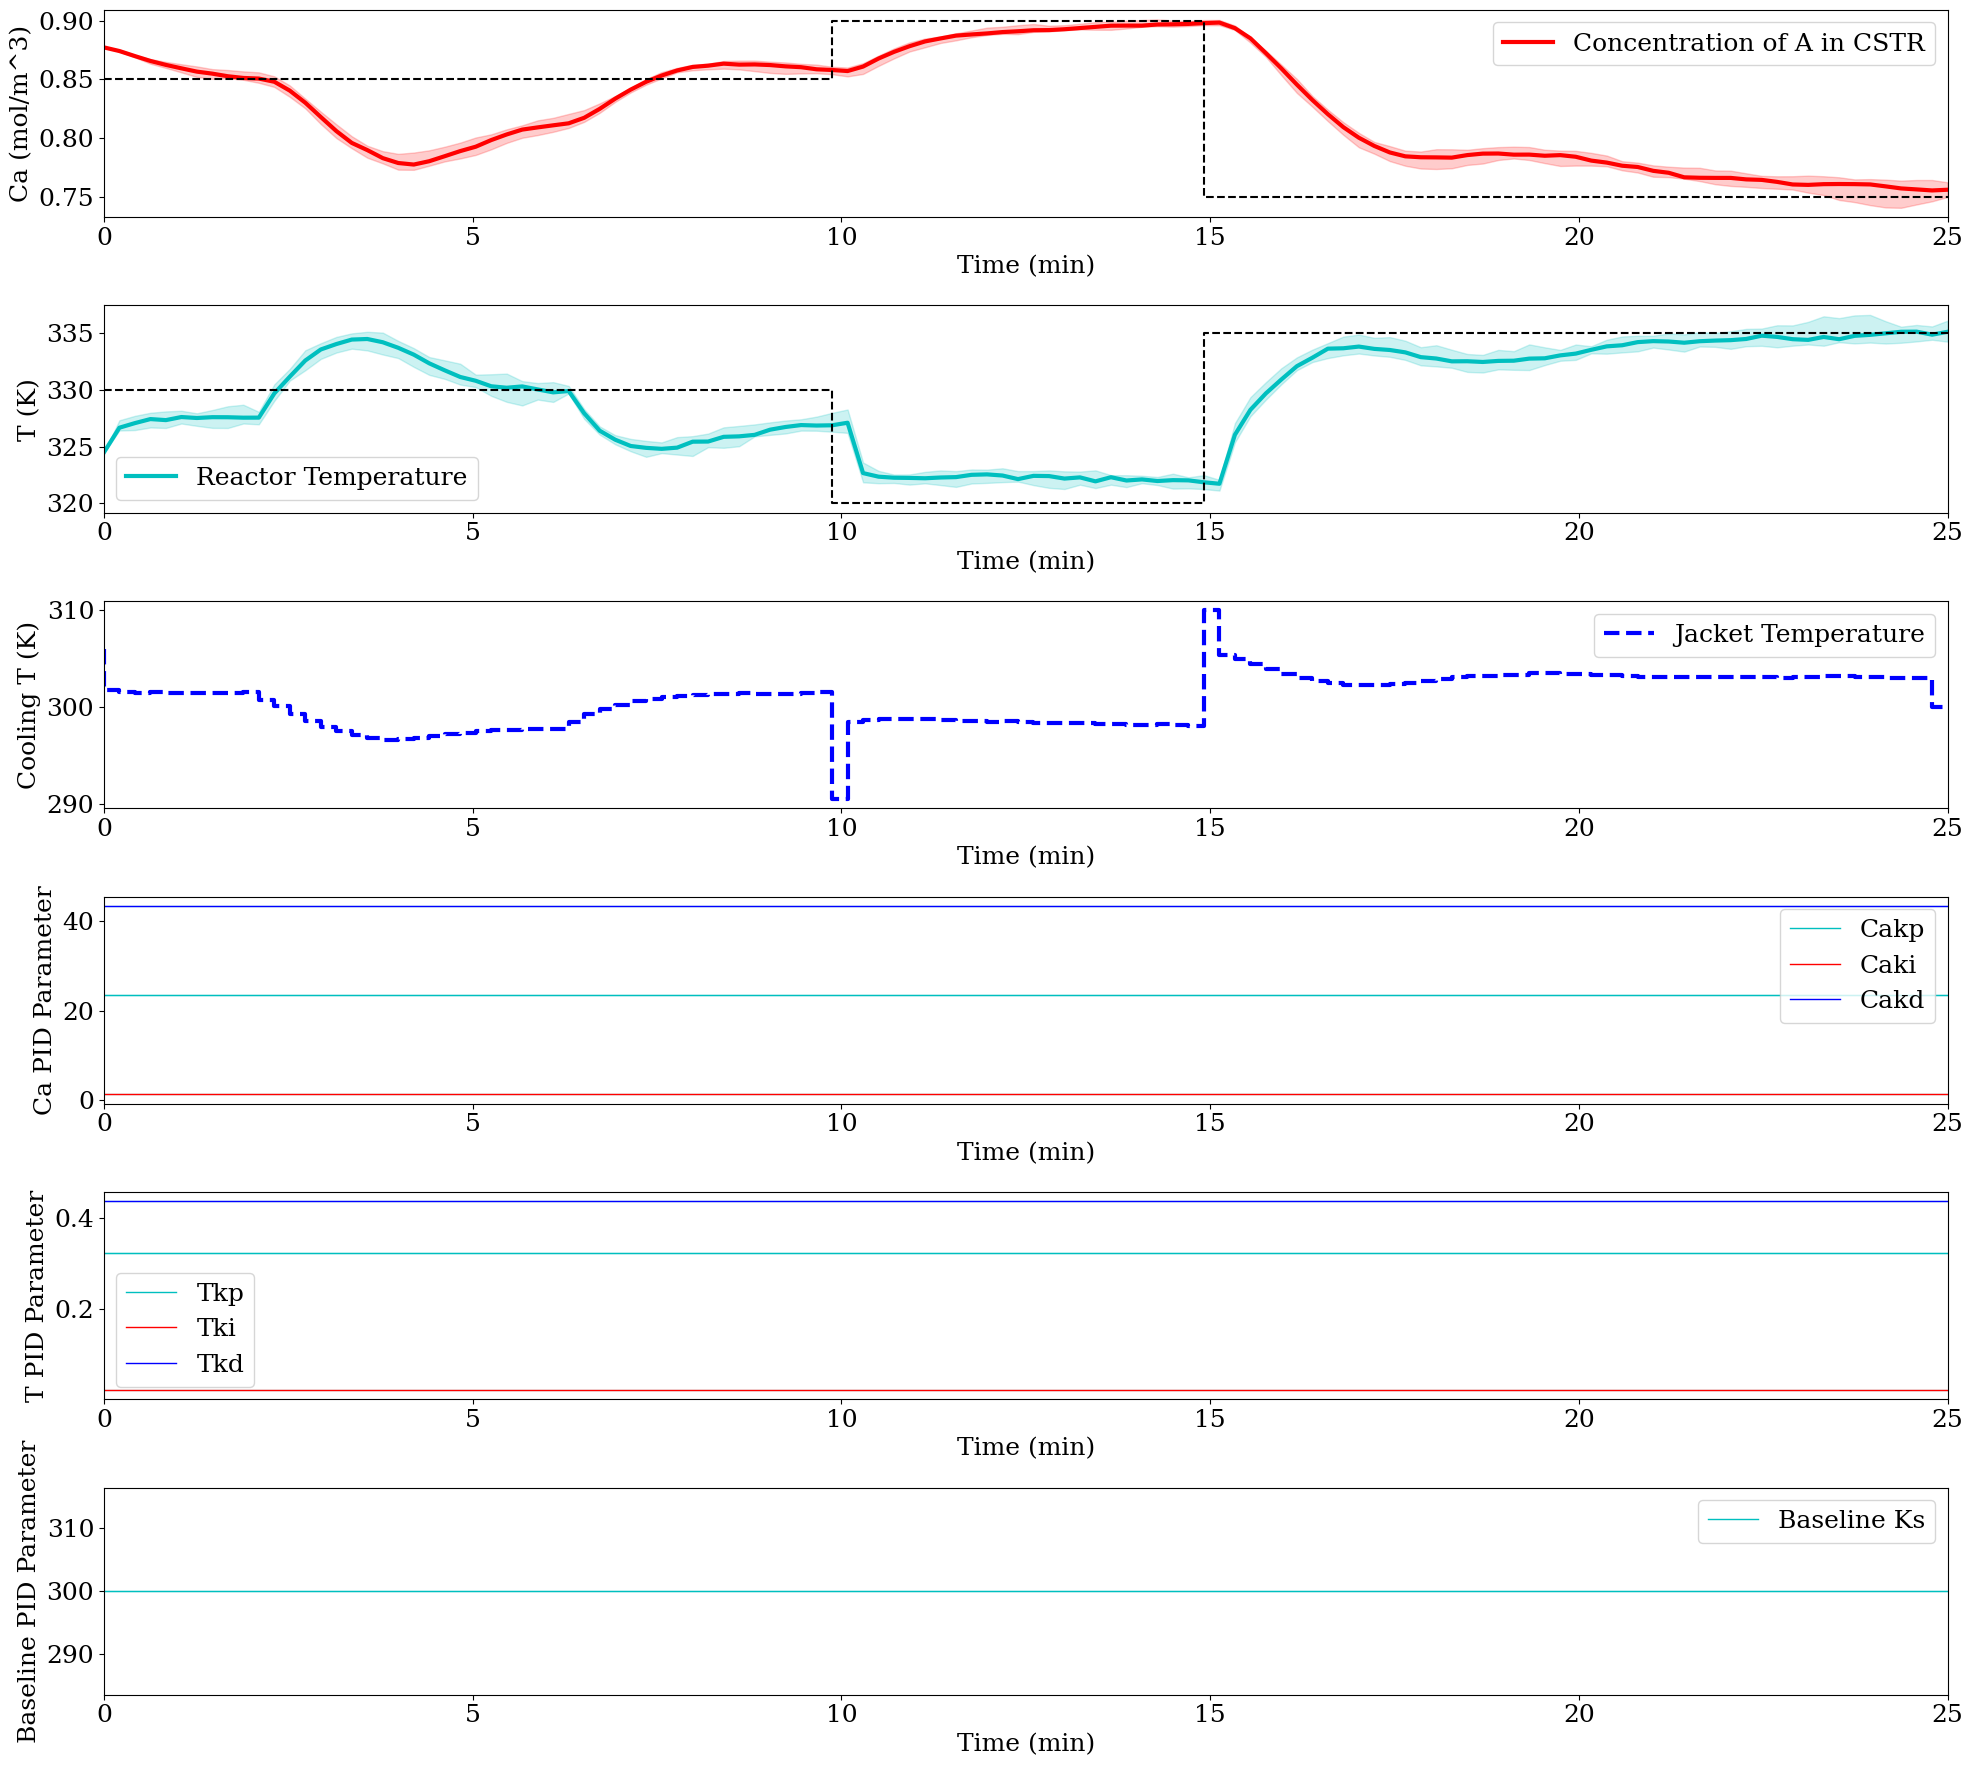

In [274]:
ns = 120
reps = 10
# Ca_des = [0.8 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.8 for i in range(int(2*ns/5))]
# T_des = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [330 for i in range(int(2*ns/5))]
Ca_des = [0.85 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.75 for i in range(int(2*ns/5))]
T_des  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [335 for i in range(int(2*ns/5))]
SP = np.array([Ca_des,T_des])
k0     = 7.2e10 # Pre-exponential factor (1/sec)
UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)

Ks_T_relay = relay_tune("T",Case_Study_1_OnOff)
Ks_Ca_relay = relay_tune("Ca",Case_Study_1_OnOff)

Ks_relay = np.array([Ks_Ca_relay[0],Ks_Ca_relay[1],Ks_Ca_relay[2],Ks_T_relay[0],Ks_T_relay[1],Ks_T_relay[2],300])

reps = 10
Ca_relay_eval = np.zeros((ns,reps))
T_relay_eval = np.zeros((ns,reps))
Tc_relay_eval = np.zeros((ns,reps))
ks_relay_evals = np.tile(Ks_relay,(reps,ns,7)).T

for r_i in range(reps):
  data_Ks_relay = Case_Study_1(Ks_relay,cstr_CS1,1,SP,ns,True,True,True,k0,UA)
  Ca_relay_eval[:,r_i] = data_Ks_relay['Ca']
  T_relay_eval[:,r_i] = data_Ks_relay['T']
  Tc_relay_eval[:,r_i] = data_Ks_relay['u']

plot_simulation(Ca_relay_eval, T_relay_eval, Tc_relay_eval,ks_relay_evals,SP,ns)

In [300]:
Ks_relay

array([2.35558678e+01, 1.33407018e+00, 4.33259711e+01, 3.22571661e-01,
       2.48897887e-02, 4.35471743e-01, 3.00000000e+02])

# NMPC

In [121]:
def R_sim(u,x,k0,UA,i):
  Caf = 1
  t = np.linspace(0,25,120)
  Tf  = np.ones(len(t)) * 350
  Tf[10:30] = 360
  
  
  ts = [t[i],t[i+1]]
  
  y       = odeint(cstr_CS1,x.reshape(2),ts,args=(u,Tf[i],Caf,k0,UA))
  
  Ca = y[-1][0] + np.random.uniform(low=-0.001,high=0.001)
  T  = y[-1][1] + np.random.uniform(low=-.5,high=0.5)
  x1 = np.array([Ca,T])
  return x1

In [253]:

def NMPC(k0_real,UA_real,reps):
    # == initial state of mpc, simulator and estimator == #
    C_a_0 = 0.87
    T_0 = 324
    T_j_0 = 300

    # == Simulation parameters and Data structures == #
    t_s = 25/120
    #reps = 10
    ns = 120
    u0_NMPC_CS1 = np.zeros((ns,reps))

    x0_NMPC_CS1 = np.zeros((2,ns,reps))
    y_next = np.zeros((2,ns,reps))
    x0 = np.array([C_a_0, T_0])

    # == Setpoint == #
    Ca_des= [0.8 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.8 for i in range(int(2*ns/5))]
    T_des  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [330 for i in range(int(2*ns/5))]
    SP = np.array([Ca_des,T_des])

    # == Additive Process noise == #
    Ca_noise = np.random.uniform(low=-0.001,high=0.001)
    T_noise = np.random.uniform(low=-.5,high=0.5)
    w0 = np.array([Ca_noise,T_noise]).reshape(2,1)

    # == Closed-loop Simulation == #
    for r_i in range(reps):
      # == Model == #
      model_type = 'continuous'
      model_real = do_mpc.model.Model(model_type)
      # States
      C_a = model_real.set_variable(var_type='_x', var_name='C_a', shape=(1,1)) # Concentration of A in the reactor
      T = model_real.set_variable(var_type='_x', var_name='T',shape=(1,1)) # Temperature inside the reactor

      #Time-varying parameters
      T_SP = model_real.set_variable(var_type='_tvp',var_name ='T_SP',shape=(1,1))
      Ca_SP = model_real.set_variable(var_type='_tvp',var_name ='Ca_SP',shape=(1,1))
      Tf  = model_real.set_variable(var_type='_tvp',var_name = 'Tf',shape=(1,1))

      # Control inputs
      Tj = model_real.set_variable(var_type='_u', var_name='Tj',shape=(1,1)) # Temperature in the jacket
      # == Process parameters == #
      q      = 100    # Volumetric Flowrate (m^3/sec)
      V      = 100    # Volume of CSTR (m^3)
      rho    = 1000   # Density of A-B Mixture (kg/m^3)
      Cp     = 0.239  # Heat capacity of A-B Mixture (J/kg-K)
      mdelH  = 5e4    # Heat of reaction for A->B (J/mol)
      EoverR = 8750   # E -Activation energy (J/mol), R -Constant = 8.31451 J/mol-K
      k0_real     # Pre-exponential factor (1/sec)
      UA_real         # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
      Caf = 1


      # == Auxiliary terms == #
      rA     = k0_real*np.exp(-EoverR/T)*C_a # reaction rate

      # == ODEs == #
      model_real.set_rhs('C_a', q/V*(Caf - C_a) - rA,process_noise=True )
      model_real.set_rhs('T', q/V*(Tf - T) + mdelH/(rho*Cp)*rA  + UA_real/V/rho/Cp*(Tj-T),process_noise=True )
      model_real.setup()
      
      
      # == Model == #
      model_type = 'continuous'
      model = do_mpc.model.Model(model_type)
      # States
      C_a = model.set_variable(var_type='_x', var_name='C_a', shape=(1,1)) # Concentration of A in the reactor
      T = model.set_variable(var_type='_x', var_name='T',shape=(1,1)) # Temperature inside the reactor

      #Time-varying parameters
      T_SP = model.set_variable(var_type='_tvp',var_name ='T_SP',shape=(1,1))
      Ca_SP = model.set_variable(var_type='_tvp',var_name ='Ca_SP',shape=(1,1))
      Tf  = model.set_variable(var_type='_tvp',var_name = 'Tf',shape=(1,1))

      # Control inputs
      Tj = model.set_variable(var_type='_u', var_name='Tj',shape=(1,1)) # Temperature in the jacket
      # == Process parameters == #
      q      = 100    # Volumetric Flowrate (m^3/sec)
      V      = 100    # Volume of CSTR (m^3)
      rho    = 1000   # Density of A-B Mixture (kg/m^3)
      Cp     = 0.239  # Heat capacity of A-B Mixture (J/kg-K)
      mdelH  = 5e4    # Heat of reaction for A->B (J/mol)
      EoverR = 8750   # E -Activation energy (J/mol), R -Constant = 8.31451 J/mol-K
      k0     = 7.2e10 # Pre-exponential factor (1/sec)
      UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
      Caf = 1


      # == Auxiliary terms == #
      rA     = k0*np.exp(-EoverR/T)*C_a # reaction rate

      # == ODEs == #
      model.set_rhs('C_a', q/V*(Caf - C_a) - rA,process_noise=True )
      model.set_rhs('T', q/V*(Tf - T) + mdelH/(rho*Cp)*rA  + UA/V/rho/Cp*(Tj-T),process_noise=True )
      model.setup()

      # == Controller == #
      mpc = do_mpc.controller.MPC(model)
      setup_mpc = {
          'n_horizon': 5,
          'n_robust': 0,
          'open_loop': 0,
          't_step': t_s,
          'state_discretization': 'collocation',
          'collocation_type': 'radau',
          'collocation_deg': 2,
          'collocation_ni': 2,
          'store_full_solution': False,

      }

      mpc.set_param(**setup_mpc)
      #mpc.scaling['_x', 'T'] = 100
      #mpc.scaling['_u', 'Tj'] = 100

      _x = model.x
      lterm =  ((_x['C_a'] - model.tvp['Ca_SP'])+(_x['T'] - model.tvp['T_SP']))**2
      mterm = DM(0)


      mpc.set_objective(mterm=mterm, lterm=lterm)

      mpc.set_rterm(Tj=0.1) # input penalty

      tvp_template_mpc = mpc.get_tvp_template()

      ns = 120
      Tf_arr = np.ones(ns+1000)*350
      Tf_arr[10:30] = 360
      def tvp_fun(t_now):
        t_now = t_now/t_s
        Ca_des_test = [0.85 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.75 for i in range(int(2*ns/5)+10000)]
        T_des_test  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [335 for i in range(int(2*ns/5)+10000)] 
        # Ca_des_test = [0.8 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.8 for i in range(int(2*ns/5)+10000)]
        # T_des_test  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [330 for i in range(int(2*ns/5)+10000)]

        for k in range(setup_mpc['n_horizon']):
          tvp_template_mpc['_tvp',k,'T_SP'] = T_des_test[int(t_now+k)]
          tvp_template_mpc['_tvp',k,'Ca_SP'] = Ca_des_test[int(t_now+k)]
          tvp_template_mpc['_tvp',k,'Tf'] = Tf_arr[int(t_now+k)]

        return tvp_template_mpc
      mpc.set_tvp_fun(tvp_fun)
      # lower bounds of the states
      mpc.bounds['lower', '_x', 'C_a'] = 0
      mpc.bounds['lower', '_x', 'T'] = 200

      # upper bounds of the states
      mpc.bounds['upper', '_x', 'C_a'] = 1.5
      mpc.bounds['upper', '_x', 'T'] = 400


      # lower bounds of the inputs
      mpc.bounds['lower', '_u', 'Tj'] = 290


      # upper bounds of the inputs
      mpc.bounds['upper', '_u', 'Tj'] = 310
      mpc.setup()

      # == Estimator == #
      estimator = do_mpc.estimator.StateFeedback(model_real)

      # == Simulator == #
      simulator = do_mpc.simulator.Simulator(model_real)
      params_simulator = {
          'integration_tool': 'cvodes',
          'abstol': 1e-10,
          'reltol': 1e-10,
          't_step': t_s
      }
      tvp_template = simulator.get_tvp_template()


      def tvp_fun(t_now):
            t_now = t_now/t_s
            Ca_des_test = [0.85 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.75 for i in range(int(2*ns/5)+10000)]
            T_des_test  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [335 for i in range(int(2*ns/5)+10000)]
            # Ca_des_test = [0.8 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.8 for i in range(int(2*ns/5)+10000)]
            # T_des_test  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [330 for i in range(int(2*ns/5)+10000)]
            tvp_template['T_SP'] = T_des_test[int(t_now)]
            tvp_template['Ca_SP'] = Ca_des_test[int(t_now)]
            tvp_template['Tf'] = Tf_arr[int(t_now)]
            return tvp_template

      # Set the tvp_fun:
      simulator.set_tvp_fun(tvp_fun)
      simulator.set_param(**params_simulator)
      simulator.setup()

      C_a_0 = 0.87
      T_0 = 324
      T_j_0 = 300

      x0 = np.array([C_a_0, T_0]).reshape(-1,1)
      mpc.x0 = x0
      simulator.x0 = x0
      estimator.x0 = x0
      mpc.set_initial_guess()
      ## == Closed-loop Simulation == #
      for k in range(ns-1):
          if k == 0:
            u0_NMPC_CS1[k,r_i] = mpc.make_step(x0)
            x0_NMPC_CS1[:,k,r_i] = x0.reshape(2)
          else:
            u0_NMPC_CS1[k,r_i] = mpc.make_step(x0_NMPC_CS1[:,k,r_i].reshape(-1,1))
          Ca_noise = np.random.uniform(low=-0.001,high=0.001)
          T_noise = np.random.uniform(low=-.5,high=0.5)
          w0 = np.array([Ca_noise,T_noise]).reshape(2,1)
          y_next[:,k,r_i] = simulator.make_step(u0_NMPC_CS1[k,r_i].reshape(1,1),w0 = w0).reshape(2) 
          x0_NMPC_CS1[:,k+1,r_i] = estimator.make_step(y_next[:,k,r_i])
    return x0_NMPC_CS1,u0_NMPC_CS1

# Comparison

In [18]:
def plot_comparison(Ca_dat, T_dat, Tc_dat,SP,ns,ks_eval,savefig):
    
    Ca_des = SP[0]
    T_des  = SP[1]
    t = np.linspace(0,25,ns)
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(20, 18))

    ax1 = plt.subplot(611)
    plt.plot(t, np.median(Ca_dat[0],axis=1), 'r-', lw=2, label = 'RL-PID')
    plt.gca().fill_between(t, np.min(Ca_dat[0],axis=1), np.max(Ca_dat[0],axis=1),
                           color='r', alpha=0.2)
    plt.plot(t, np.median(Ca_dat[1],axis=1), 'b-', lw=2, label = 'DFO-PID')
    plt.gca().fill_between(t, np.min(Ca_dat[1],axis=1), np.max(Ca_dat[1],axis=1),
                           color='b', alpha=0.2)
    plt.plot(t, np.median(Ca_dat[2],axis=1), 'g-', lw=2,label = 'Relay-PID')
    plt.gca().fill_between(t, np.min(Ca_dat[2],axis=1), np.max(Ca_dat[2],axis=1),
                           color='g', alpha=0.2)
    plt.plot(t, np.median(Ca_dat[3],axis=1), 'c-', lw=2,label = 'NMPC')
    plt.gca().fill_between(t, np.min(Ca_dat[3],axis=1), np.max(Ca_dat[3],axis=1),
                           color='c', alpha=0.2)
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('C$_A$ [mol/m$^3$]')
    #plt.xlabel('Time [min]')
    plt.legend(loc='upper right', prop={'size': 14})
    plt.tick_params('x', labelbottom=False)
    plt.ylim(0.7,1)

    plt.subplot(612,sharex = ax1)
    plt.plot(t, np.median(T_dat[0],axis=1), 'r-', lw=2,label = 'RL-PID')
    plt.gca().fill_between(t, np.min(T_dat[0],axis=1), np.max(T_dat[0],axis=1),
                           color='r', alpha=0.2)

    plt.plot(t, np.median(T_dat[1],axis=1), 'b-', lw=2, label = 'DFO-PID')
    plt.gca().fill_between(t, np.min(T_dat[1],axis=1), np.max(T_dat[1],axis=1),
                           color='b', alpha=0.2)
    plt.plot(t, np.median(T_dat[2],axis=1), 'g-', lw=2,label = 'Relay-PID')
    plt.gca().fill_between(t, np.min(T_dat[2],axis=1), np.max(T_dat[2],axis=1),
                           color='g', alpha=0.2)
    plt.plot(t, np.median(T_dat[3],axis=1), 'c-', lw=2,label = 'NMPC')
    plt.gca().fill_between(t, np.min(T_dat[3],axis=1), np.max(T_dat[3],axis=1),
                           color='c', alpha=0.2)
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T [K]')
    #plt.xlabel('Time [min]')
    #plt.legend(loc='upper right')
    plt.tick_params('x', labelbottom=False)
    plt.xlim(min(t), max(t))


    plt.subplot(613,sharex = ax1)
    plt.step(t, np.median(Tc_dat[0],axis=1), 'r--', lw=2,label = 'RL-PID')
    plt.step(t, np.median(Tc_dat[1],axis=1), 'b--', lw=2, label = 'DFO-PID')
    plt.step(t, np.median(Tc_dat[2],axis=1), 'g--', lw=2,label = 'Relay-PID')
    plt.step(t[:-1], np.median(Tc_dat[3],axis=1)[:-1], 'c--', lw=2,label = 'NMPC')
    plt.ylabel('Jacket Temperature [K]')
    #plt.xlabel('Time [min]')
    #plt.legend(loc='upper right')
    plt.tick_params('x', labelbottom=False)
    plt.xlim(min(t), max(t))
    
    labels = ['K$_p$','K$_i$','K$_d$','K$_p$','K$_i$','K$_d$']
    col = ['c-','m-','y-','c-','m-','y-']
    col_fill = ['c','m','y','c','m','y']
    plt.subplot(614,sharex = ax1)
    for ks_i in range(3):
      plt.plot(t, np.median(ks_eval[ks_i,:,:],axis=1), col[ks_i], lw=2,label = labels[ks_i])
      plt.gca().fill_between(t, np.min(ks_eval[ks_i,:,:],axis=1), np.max(ks_eval[ks_i,:,:],axis=1),
                              color=col_fill[ks_i], alpha=0.2)
    plt.ylabel('Ca PID Parameter')
    #plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))
    plt.tick_params('x', labelbottom=False)
    plt.subplot(6,1,5)
    
    i = [3,4,5]
    for ks_i in i:
      plt.plot(t, np.median(ks_eval[ks_i,:,:],axis=1), col[ks_i], lw=2,label = labels[ks_i])
      plt.gca().fill_between(t, np.min(ks_eval[ks_i,:,:],axis=1), np.max(ks_eval[ks_i,:,:],axis=1),
                              color=col_fill[ks_i], alpha=0.2)
    plt.ylabel('T PID Parameter')
    plt.xlabel('Time [min]')
    #plt.legend(loc='best')
    plt.xlim(min(t), max(t))


    plt.tight_layout()
    if savefig == True:
        plt.savefig('CS1.pdf')
    plt.show()

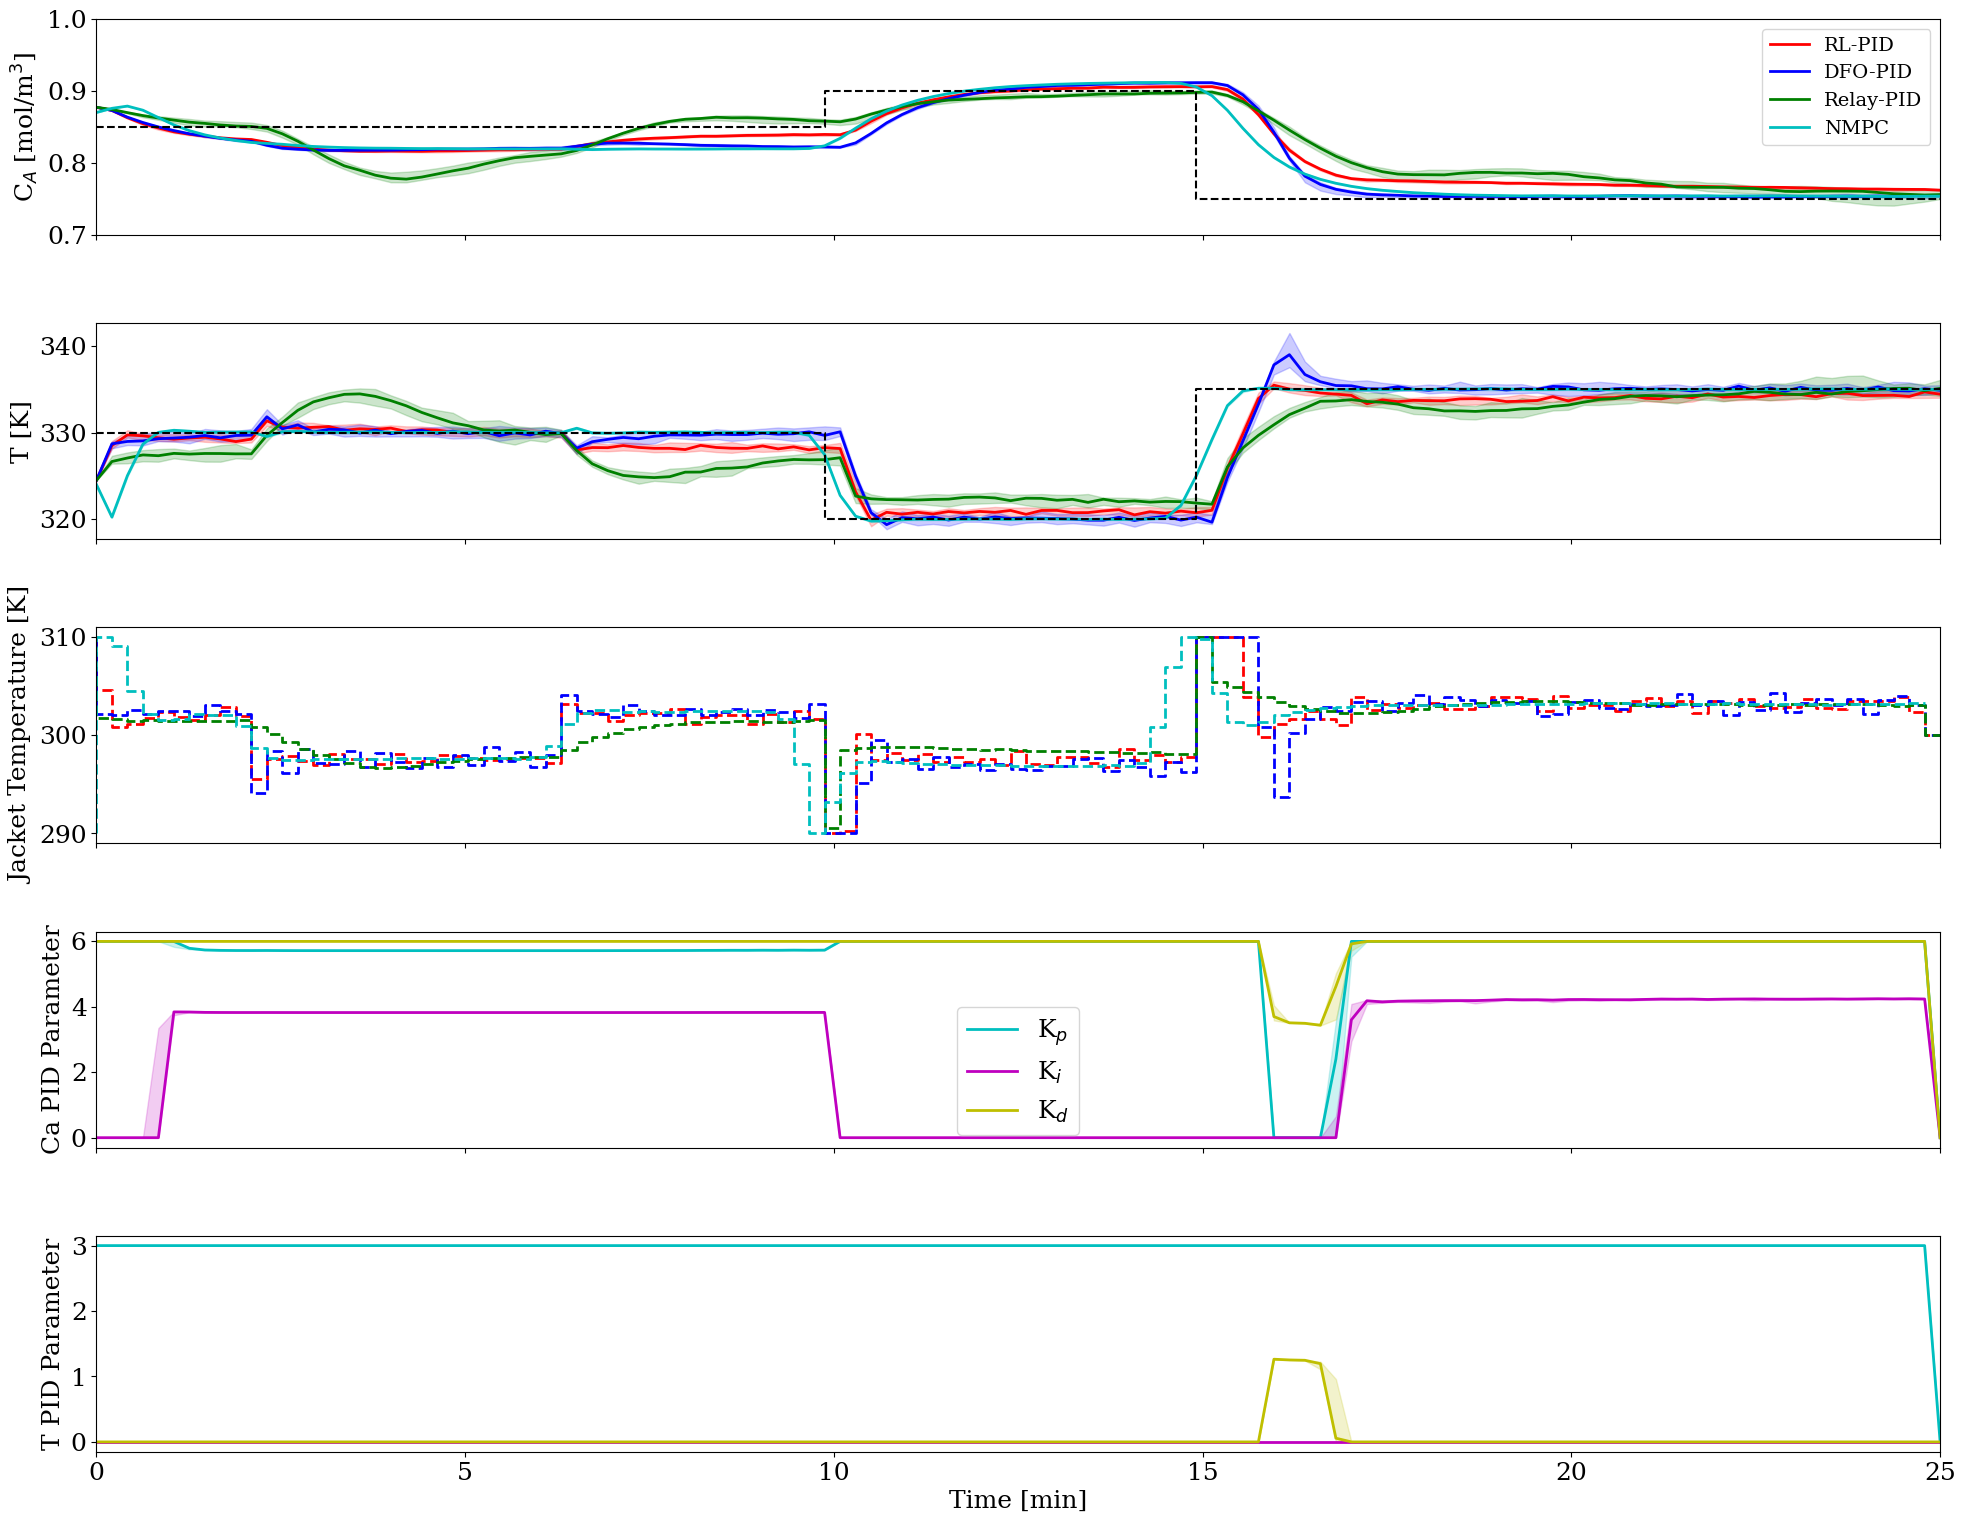

=== Ca-ISE ===
RL-PID : 0.151
DFO-PID : 0.154
Relay-PID : 0.204
NMPC : 0.108
=== T-ISE ===
RL-PID : 529.853
DFO-PID : 583.137
Relay-PID : 1118.997
NMPC : 238.501


In [275]:
k0     = 7.2e10 # Pre-exponential factor (1/sec)
UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
#x0_NMPC_CS1,u0_NMPC_CS1 = NMPC(k0,UA,10)
Ca_dat = np.array([Ca_eval,Ca_ks_eval,Ca_relay_eval,x0_NMPC_CS1[0,:,:]])
T_dat = np.array([T_eval,T_ks_eval,T_relay_eval,x0_NMPC_CS1[1,:,:]])
Tc_dat = np.array([Tc_eval,Tc_ks_eval,Tc_relay_eval,u0_NMPC_CS1])
Ca_des = [0.85 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.75 for i in range(int(2*ns/5))]
T_des  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [335 for i in range(int(2*ns/5))]
# Ca_des = [0.8 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.8 for i in range(int(2*ns/5))]
# T_des = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [330 for i in range(int(2*ns/5))]
SP = np.array([Ca_des,T_des])

plot_comparison(Ca_dat,T_dat, Tc_dat,SP,120,ks_eval,True)
IAE_Ca = np.zeros(4)
IAE_T = np.zeros_like(IAE_Ca)
methods = ['RL-PID','DFO-PID','Relay-PID','NMPC']
for i in range(4):
  IAE_Ca[i] = sum((np.median(Ca_dat[i],axis=1)-Ca_des)**2)
  IAE_T[i] = sum((np.median(T_dat[i],axis=1)-T_des)**2)
print('=== Ca-ISE ===')
for i in range(4):
   print(methods[i],':',round(IAE_Ca[i],3))
print('=== T-ISE ===')
for i in range(4):
  print(methods[i],':',round(IAE_T[i],3))

In [347]:
Time_series_data = np.array((Ca_dat,T_dat,Tc_dat))
np.save('Time_series_data_CS1.npy',Time_series_data)


# Parametric Drift

In [294]:
%%capture
k0     = 7.2e10 # Pre-exponential factor (1/sec)
UA = np.linspace(3e4,5e4,20)

#Plot results
reps = 10
ns = 120
Ca_eval_UA = np.zeros((ns))
T_eval_UA = np.zeros((ns))
Tc_eval_UA = np.zeros((ns))


Ca_des = [0.85 for i in range(int(2*ns/5))] + [0.9 for i in range(int(ns/5))] + [0.75 for i in range(int(2*ns/5))]
T_des  = [330 for i in range(int(2*ns/5))] + [320 for i in range(int(ns/5))] + [335 for i in range(int(2*ns/5))]
SP = np.array([Ca_des,T_des])
IAE_Ca_UA = np.zeros((UA.shape[0],4, reps))
IAE_T_UA = np.zeros_like(IAE_Ca_UA)
for r_i in range(reps):
  for i in range(UA.shape[0]):

      data_RL_UA = Case_Study_1(0,cstr_CS1,best_policy,SP,ns,False,True,True,k0,UA[i]) #Disturbance active
      data_Ks_relay_UA = Case_Study_1(Ks_relay,cstr_CS1,1,SP,ns,True,True,True,k0,UA[i])
      data_KsOpt_UA = Case_Study_1(Ks_opt,cstr_CS1,1,SP_test,ns,True,True,True,k0,UA[i])
      Ca_eval_UA = data_RL_UA['Ca']
      T_eval_UA = data_RL_UA['T']
      Tc_eval_UA = data_RL_UA['u']
      Ca_relay_eval_UA = data_Ks_relay_UA['Ca']
      T_relay_eval_UA = data_Ks_relay_UA['T']
      Tc_relay_eval_UA = data_Ks_relay_UA['u']

      Ca_ks_eval_UA = data_KsOpt_UA['Ca']
      T_ks_eval_UA = data_KsOpt_UA['T']
      Tc_ks_eval_UA = data_KsOpt_UA['u']
      x0_NMPC_CS1_UA,u0_NMPC_CS1_UA= NMPC(k0,UA[i],1)
      print('UA:',UA[i])

      methods = ['RL-PID','DFO-PID','Relay-PID','NMPC']
      Ca_dat_UA = np.array([data_RL_UA['Ca'],data_KsOpt_UA['Ca'],data_Ks_relay_UA['Ca'],x0_NMPC_CS1_UA[0,:,0]])
      T_dat_UA = np.array([data_RL_UA['T'],data_KsOpt_UA['T'],data_Ks_relay_UA['T'],x0_NMPC_CS1_UA[1,:,0]])
      Tc_dat_UA = np.array([data_RL_UA['u'],data_KsOpt_UA['u'],data_Ks_relay_UA['u'],u0_NMPC_CS1_UA[0]],dtype = object)

      for i_ISE in range(4):
        IAE_Ca_UA[i,i_ISE,r_i] = sum((Ca_dat_UA[i_ISE]-Ca_des)**2)
        IAE_T_UA[i,i_ISE,r_i] = sum((T_dat_UA[i_ISE]-T_des)**2)






In [349]:
param_mis_UA = np.array((IAE_Ca_UA,IAE_T_UA))
np.save('param_mis_UA_CS1.npy',param_mis_UA)

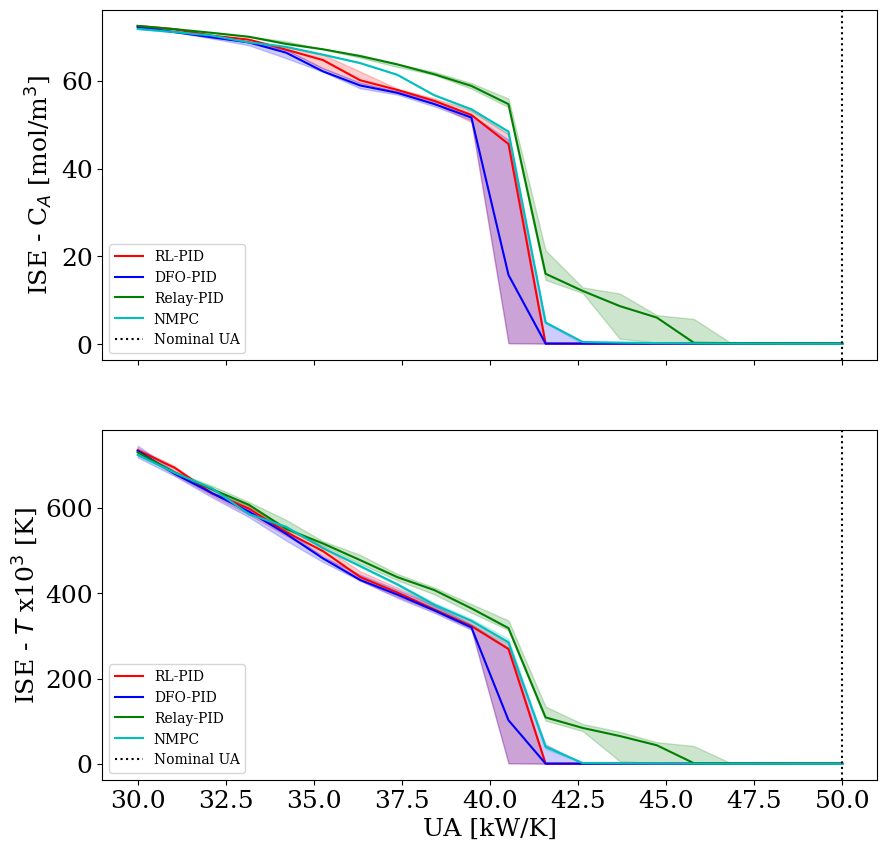

In [337]:
UA = np.linspace(3e4,5e4,20)/1000
col = ['r','b','g','c']
plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)


for i in range(4):
    plt.plot(UA,np.median(IAE_Ca_UA[:,i,:],axis=1),color = col[i],label = methods[i])
    plt.gca().fill_between(UA, np.min(IAE_Ca_UA[:,i,:],axis=1), np.max(IAE_Ca_UA[:,i,:],axis=1),color = col[i],alpha=0.2)
plt.axvline(x = 5e1, color = 'black', linestyle = 'dotted', label = 'Nominal UA')
plt.ylabel('ISE - C$_A$ [mol/m$^3$]')
plt.tick_params('x', labelbottom=False)
#plt.xlabel('UA [kW/K]')
plt.legend(prop={'size': 10})

plt.subplot(212, sharex = ax1)
for i in range(4):
    plt.plot(UA,np.median(IAE_T_UA[:,i,:],axis=1)/1000,color = col[i],label = methods[i])
    plt.gca().fill_between(UA, np.min(IAE_T_UA[:,i,:]/1000,axis=1), np.max(IAE_T_UA[:,i,:]/1000,axis=1),color = col[i],alpha=0.2)
plt.axvline(x = 5e1, color = 'black', linestyle = 'dotted', label = 'Nominal UA')
plt.ylabel('ISE - $T$ x10$^{3}$ [K] ')
plt.xlabel('UA [kW/K]')
plt.legend( prop={'size': 10})
plt.savefig('CS1_ParaMis_UA.pdf')
plt.show()

In [296]:
%%capture
k0 = np.linspace(1e10,7.2e10,20)
UA = 5e4
reps = 10
IAE_Ca_k0 = np.zeros((k0.shape[0],4,reps))
IAE_T_k0 = np.zeros_like(IAE_Ca_k0)
for r_i in range(reps):
  for i in range(k0.shape[0]):
      data_RL_k0 = Case_Study_1(0,cstr_CS1,best_policy,SP,ns,False,True,True,k0[i],UA) #Disturbance active
      data_Ks_relay_k0 = Case_Study_1(Ks_relay,cstr_CS1,1,SP,ns,True,True,True,k0[i],UA)
      data_KsOpt_k0 = Case_Study_1(Ks_opt,cstr_CS1,1,SP_test,ns,True,True,True,k0[i],UA)
      x0_NMPC_CS1_k0,u0_NMPC_CS1_k0= NMPC(k0[i],UA,1)
      

      methods = ['RL-PID','DFO-PID','Relay-PID','NMPC']
      Ca_dat_k0 = np.array([data_RL_k0['Ca'],data_KsOpt_k0['Ca'],data_Ks_relay_k0['Ca'],x0_NMPC_CS1_k0[0,:,0]])
      T_dat_k0 = np.array([data_RL_k0['T'],data_KsOpt_k0['T'],data_Ks_relay_k0['T'],x0_NMPC_CS1_k0[1,:,0]])
      Tc_dat_k0 = np.array([data_RL_k0['u'],data_KsOpt_k0['u'],data_Ks_relay_k0['u'],u0_NMPC_CS1_k0[0]],dtype = object)

      for i_ISE in range(4):
        IAE_Ca_k0[i,i_ISE,r_i] = sum((Ca_dat_k0[i_ISE]-Ca_des)**2)
        IAE_T_k0[i,i_ISE,r_i] = sum((T_dat_k0[i_ISE]-T_des)**2)


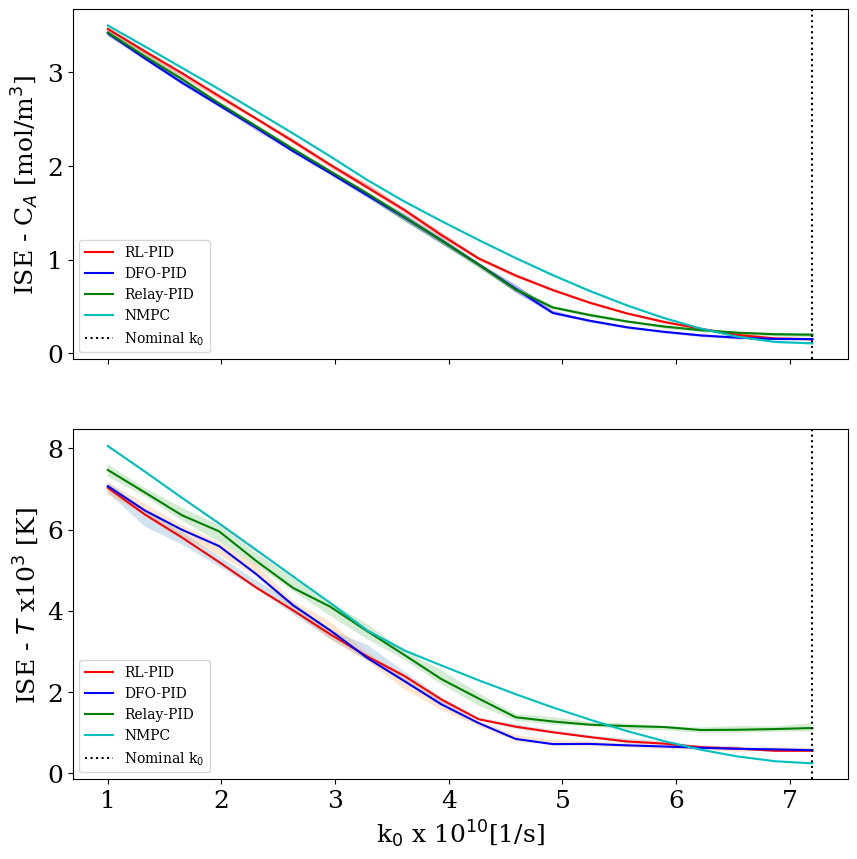

In [340]:
k0 = np.linspace(1e10,7.2e10,20)/1e10
plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)

for i in range(4):
    plt.plot(k0,np.median(IAE_Ca_k0[:,i,:],axis=1),color = col[i],label = methods[i])
    plt.gca().fill_between(k0, np.min(IAE_Ca_k0[:,i,:],axis=1), np.max(IAE_Ca_k0[:,i,:],axis=1),color = col[i],alpha=0.2)
plt.axvline(x = 7.2,color = 'black', linestyle = 'dotted',label = 'Nominal k$_0$')
#plt.xlabel('k0')
plt.tick_params('x', labelbottom=False)
plt.ylabel('ISE - C$_A$ [mol/m$^3$]')
plt.legend(prop={'size': 10})


plt.subplot(212,sharex = ax1)

for i in range(4):
    plt.plot(k0,np.median(IAE_T_k0[:,i,:]/1000,axis=1),color = col[i],label = methods[i])
    plt.gca().fill_between(k0, np.min(IAE_T_k0[:,i,:]/1000,axis=1), np.max(IAE_T_k0[:,i,:]/1000,axis=1),alpha=0.2)
plt.axvline(x = 7.2, color = 'black', linestyle = 'dotted',label = 'Nominal k$_0$')
plt.xlabel('k$_0$ x 10$^{10}$[1/s]')
plt.ylabel('ISE - $T$ x10$^{3}$ [K] ')
plt.yscale('linear')
plt.legend(prop={'size': 10})
plt.savefig('CS1_ParaMis_k0.pdf')
plt.show()

In [350]:
param_mis_k0 = np.array((IAE_Ca_k0,IAE_T_k0))
np.save('param_mis_k0_CS1.npy',param_mis_k0)